# Adding the CETCH cycle to a diel plant FBA model

- adding the CETCH cycle to the carbon-limited (PEPC-constrained) plant diel model

In [285]:
from scipy import stats


In [286]:
df_list = []
df_name_list = []

In [287]:
models = []
solutions = []
all_models = []

In [288]:
%run functions.py

In [289]:

model_var = "diel_plant_core_model.xml"

# define objective reaction
output_string = "AraCore_Biomass_tx"
objective_direction = "max"

day_tag = "_00"
night_tag = "_12"

charge_state_mets = False

In [290]:
# set solver for optimisation
solver = 'glpk'
cobra.core.Configuration.solver = solver
diel_model = cobra.io.read_sbml_model(model_var)
diel_model.solver

In [291]:
# photon flux constraints
diel_model.reactions.get_by_id("Photon_tx"+day_tag).upper_bound = 200
diel_model.reactions.get_by_id("Photon_tx"+night_tag).upper_bound = 0 #night-time darkness

# prevent phloem output reactions
diel_model.reactions.get_by_id("Phloem_output_tx"+day_tag).bounds = (0, 0)
diel_model.reactions.get_by_id("Phloem_output_tx"+night_tag).bounds = (0, 0)


# Rubisco C:O constraint = 3:1
set_Rubisco_C_to_O_ratio(diel_model, 3/1)


# output constraint day:night = 3:1
set_output_day_night_ratio(diel_model, 3/1, output_string)

# maintenance costs based on linear equation using light intensity, as in Toepfer et al., 2021
## maintenance day:night = 1:1

#light
PPFD = diel_model.reactions.get_by_id("Photon_tx"+day_tag).upper_bound
ATPase = (PPFD*0.0049)+2.7851

print("ATPase flux during the day: ", ATPase)

diel_model.reactions.get_by_id("ATPase_tx"+day_tag).bounds = (ATPase, ATPase)

#dark
print("ATPase flux at night: ", ATPase)
diel_model.reactions.get_by_id("ATPase_tx"+night_tag).bounds = (ATPase, ATPase)


# maintenance ATPase:NADPHoxidase = 3:1
set_NGAM_ATP_NADPH_ratio(diel_model, 3/1)
print("set maintenance ATPase:NADPHoxidase ratio to 3:1")


# nitrate day:night = 3:2
set_nitrate_uptake_day_night_ratio(diel_model, 3/2)
print("set nitrate uptake light:dark ratio to 3:2")


# amino acids accumulating day to night, not night to day
aa_day_to_night_only = True

amino_acids = ["ASN_v",
"SER_v",
"GLN_v",
"GLY_v",
"THR_v",
"L_ALPHA_ALANINE_v",
"VAL_v",
"ILE_v",
"PHE_v",
"LEU_v",
"LYS_v",
"ARG_v",
"L_ASPARTATE_v",
"GLT_v",
"HIS_v",
"MET_v",
"PRO_v",
"TRP_v",
"TYR_v",
"CYS_v"]#,
#"4_AMINO_BUTYRATE_v"]

if aa_day_to_night_only:

    for rxn in diel_model.reactions:
        if "_12_to_00" in rxn.id and rxn.id[:-16] in amino_acids:
            rxn.upper_bound = 0
            # print(rxn.id[:-16])
    print("set amino acid accumulation to day to night only")
else:
    pass

ATPase flux during the day:  3.7651
ATPase flux at night:  3.7651
set maintenance ATPase:NADPHoxidase ratio to 3:1
set nitrate uptake light:dark ratio to 3:2
set amino acid accumulation to day to night only


In [292]:
# set objective
diel_model.objective = {diel_model.reactions.get_by_id(output_string+"_total"): 1}
diel_model.objective_direction = objective_direction

print("Objective set to :",str(diel_model.objective_direction), output_string+"_total")




Objective set to : max AraCore_Biomass_tx_total


In [293]:
# from cobra.flux_analysis import pfba
# solution = pfba(diel_model)

In [294]:
# scan over upper bound on CO2 uptake, while constraining PEPCs at night, to value in C3 behaviour model
PEPC_slope = 2.184


diel_model_noCAM = diel_model.copy()
set_PEPC_C3_constraints(diel_model_noCAM, slope=PEPC_slope, objective = "AraCore_Biomass_tx_total")

df_C1, sol_C1 = parameter_scan_CO2(diel_model_noCAM, "AraCore_Biomass_tx_total", "CO2_tx_00", 0, 17, 1, pFBA=True, 
                    CO2_refixation_allowed=True, verbose=True, iterations=50, 
                    double_ub = False, m=0.01025582745716949, b =-0.01170011252656307)


Setting new PEPC_obj_const constraint, with slope 2.184 .
Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total


Model iteration feasible. Objective flux: 0.0003446
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.000753
producing HCO3-:	RXN0_5224_c_12	0.000753
producing CO2:	CO2_pc_12	0.210023
consuming CO2:	ISOCITDEH_RXN_c_12	-0.418236
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	9.8e-05
producing CO2:	CO2_mc_12	1.179007
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.000753
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	2.2e-05
producing CO2:	RXN_9652_p_12	6.6e-05
producing CO2:	RXN_9650_p_12	6.6e-05
producing CO2:	RXN_5682_p_12	1.4e-05
producing CO2:	2.3.1.180_RXN_p_12	6.6e-05
producing CO2:	RXN_9654_p_12	6.6e-05
consuming CO2:	RXN0_5224_p_12	0.000465
producing HCO3-:	RXN0_5224_p_12	0.000465
consuming CO2:	CO2_pc_12	0.210023
producing CO2:	1.2.1.2_RXN_p_12	1.1e-05
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.000465
producing CO2:	PYRUVDEH_RXN_p_12	0.000532
producing CO2:	RXN_9653_p_12	6.6e-05
producing CO2:	RXN_9651_p_12	6.6e-05
consuming CO2:	CARBAMATE_KINASE_RXN_p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 3      Scan value: 2 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0118861
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.025959
producing HCO3-:	RXN0_5224_c_12	0.025959
producing CO2:	CO2_pc_12	0.238497
consuming CO2:	ISOCITDEH_RXN_c_12	-0.414616
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.003373
producing CO2:	CO2_mc_12	1.168817
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.025959
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000762
producing CO2:	RXN_9652_p_12	0.002291
producing CO2:	RXN_9650_p_12	0.002291
producing CO2:	RXN_5682_p_12	0.000492
producing CO2:	2.3.1.180_RXN_p_12	0.002291
producing CO2:	RXN_9654_p_12	0.002291
consuming CO2:	RXN0_5224_p_12	0.01604
producing HCO3-:	RXN0_5224_p_12	0.01604
consuming CO2:	CO2_pc_12	0.238497
producing CO2:	1.2.1.2_RXN_p_12	0.00038
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.01604
producing CO2:	PYRUVDEH_RXN_p_12	0.018332
produ

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 4      Scan value: 3 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0234276
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.051166
producing HCO3-:	RXN0_5224_c_12	0.051166
producing CO2:	CO2_pc_12	0.266224
consuming CO2:	ISOCITDEH_RXN_c_12	-0.410995
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.006647
producing CO2:	CO2_mc_12	1.159375
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.051166
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001502
producing CO2:	RXN_9652_p_12	0.004517
producing CO2:	RXN_9650_p_12	0.004517
producing CO2:	RXN_5682_p_12	0.000969
producing CO2:	2.3.1.180_RXN_p_12	0.004517
producing CO2:	RXN_9654_p_12	0.004517
consuming CO2:	RXN0_5224_p_12	0.031616
producing HCO3-:	RXN0_5224_p_12	0.031616
consuming CO2:	CO2_pc_12	0.266224
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.031616
producing CO2:	PYRUVDEH_RXN_p_12	0.036132
producing CO2:	RXN_9653_p_12	0.004517
prod

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 5      Scan value: 4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.034969
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.076372
producing HCO3-:	RXN0_5224_c_12	0.076372
producing CO2:	CO2_pc_12	0.29433
consuming CO2:	ISOCITDEH_RXN_c_12	-0.407375
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.009922
producing CO2:	CO2_mc_12	1.149553
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.076372
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002242
producing CO2:	RXN_9652_p_12	0.006742
producing CO2:	RXN_9650_p_12	0.006742
producing CO2:	RXN_5682_p_12	0.001446
producing CO2:	2.3.1.180_RXN_p_12	0.006742
producing CO2:	RXN_9654_p_12	0.006742
consuming CO2:	RXN0_5224_p_12	0.047191
producing HCO3-:	RXN0_5224_p_12	0.047191
consuming CO2:	CO2_pc_12	0.29433
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.047191
producing CO2:	PYRUVDEH_RXN_p_12	0.053933
producing CO2:	RXN_9653_p_12	0.006742
produci

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 6      Scan value: 5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0465105
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.101579
producing HCO3-:	RXN0_5224_c_12	0.101579
producing CO2:	CO2_pc_12	0.322436
consuming CO2:	ISOCITDEH_RXN_c_12	-0.403754
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.013197
producing CO2:	CO2_mc_12	1.139732
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.101579
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002982
producing CO2:	RXN_9652_p_12	0.008967
producing CO2:	RXN_9650_p_12	0.008967
producing CO2:	RXN_5682_p_12	0.001923
producing CO2:	2.3.1.180_RXN_p_12	0.008967
producing CO2:	RXN_9654_p_12	0.008967
consuming CO2:	RXN0_5224_p_12	0.062767
producing HCO3-:	RXN0_5224_p_12	0.062767
consuming CO2:	CO2_pc_12	0.322436
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.062767
producing CO2:	PYRUVDEH_RXN_p_12	0.071733
producing CO2:	RXN_9653_p_12	0.008967
prod

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 7      Scan value: 6 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.058052
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.126786
producing HCO3-:	RXN0_5224_c_12	0.126786
producing CO2:	CO2_pc_12	0.350543
consuming CO2:	ISOCITDEH_RXN_c_12	-0.400134
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.016471
producing CO2:	CO2_mc_12	1.12991
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.126786
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003722
producing CO2:	RXN_9652_p_12	0.011192
producing CO2:	RXN_9650_p_12	0.011192
producing CO2:	RXN_5682_p_12	0.002401
producing CO2:	2.3.1.180_RXN_p_12	0.011192
producing CO2:	RXN_9654_p_12	0.011192
consuming CO2:	RXN0_5224_p_12	0.078342
producing HCO3-:	RXN0_5224_p_12	0.078342
consuming CO2:	CO2_pc_12	0.350543
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.078342
producing CO2:	PYRUVDEH_RXN_p_12	0.089534
producing CO2:	RXN_9653_p_12	0.011192
produc

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 8      Scan value: 7 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0695934
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.151992
producing HCO3-:	RXN0_5224_c_12	0.151992
producing CO2:	CO2_pc_12	0.378649
consuming CO2:	ISOCITDEH_RXN_c_12	-0.396513
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.019746
producing CO2:	CO2_mc_12	1.120088
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.151992
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004462
producing CO2:	RXN_9652_p_12	0.013417
producing CO2:	RXN_9650_p_12	0.013417
producing CO2:	RXN_5682_p_12	0.002878
producing CO2:	2.3.1.180_RXN_p_12	0.013417
producing CO2:	RXN_9654_p_12	0.013417
consuming CO2:	RXN0_5224_p_12	0.093918
producing HCO3-:	RXN0_5224_p_12	0.093918
consuming CO2:	CO2_pc_12	0.378649
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.093918
producing CO2:	PYRUVDEH_RXN_p_12	0.107334
producing CO2:	RXN_9653_p_12	0.013417
prod

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 9      Scan value: 8 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0811349
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.177199
producing HCO3-:	RXN0_5224_c_12	0.177199
producing CO2:	CO2_pc_12	0.406755
consuming CO2:	ISOCITDEH_RXN_c_12	-0.392892
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.023021
producing CO2:	CO2_mc_12	1.110267
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.177199
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005202
producing CO2:	RXN_9652_p_12	0.015642
producing CO2:	RXN_9650_p_12	0.015642
producing CO2:	RXN_5682_p_12	0.003355
producing CO2:	2.3.1.180_RXN_p_12	0.015642
producing CO2:	RXN_9654_p_12	0.015642
consuming CO2:	RXN0_5224_p_12	0.109493
producing HCO3-:	RXN0_5224_p_12	0.109493
consuming CO2:	CO2_pc_12	0.406755
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.109493
producing CO2:	PYRUVDEH_RXN_p_12	0.125135
producing CO2:	RXN_9653_p_12	0.015642
prod

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 10      Scan value: 9 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0926764
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.202405
producing HCO3-:	RXN0_5224_c_12	0.202405
producing CO2:	CO2_pc_12	0.434861
consuming CO2:	ISOCITDEH_RXN_c_12	-0.389272
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.026296
producing CO2:	CO2_mc_12	1.100445
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.202405
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005942
producing CO2:	RXN_9652_p_12	0.017867
producing CO2:	RXN_9650_p_12	0.017867
producing CO2:	RXN_5682_p_12	0.003832
producing CO2:	2.3.1.180_RXN_p_12	0.017867
producing CO2:	RXN_9654_p_12	0.017867
consuming CO2:	RXN0_5224_p_12	0.125068
producing HCO3-:	RXN0_5224_p_12	0.125068
consuming CO2:	CO2_pc_12	0.434861
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.125068
producing CO2:	PYRUVDEH_RXN_p_12	0.142935
producing CO2:	RXN_9653_p_12	0.017867
pro

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 11      Scan value: 10 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1042178
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.227612
producing HCO3-:	RXN0_5224_c_12	0.227612
producing CO2:	CO2_pc_12	0.462968
consuming CO2:	ISOCITDEH_RXN_c_12	-0.385651
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.02957
producing CO2:	CO2_mc_12	1.090623
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.227612
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006681
producing CO2:	RXN_9652_p_12	0.020092
producing CO2:	RXN_9650_p_12	0.020092
producing CO2:	RXN_5682_p_12	0.00431
producing CO2:	2.3.1.180_RXN_p_12	0.020092
producing CO2:	RXN_9654_p_12	0.020092
consuming CO2:	RXN0_5224_p_12	0.140644
producing HCO3-:	RXN0_5224_p_12	0.140644
consuming CO2:	CO2_pc_12	0.462968
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.140644
producing CO2:	PYRUVDEH_RXN_p_12	0.160736
producing CO2:	RXN_9653_p_12	0.020092
prod

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 12      Scan value: 11 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1157593
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.252818
producing HCO3-:	RXN0_5224_c_12	0.252818
producing CO2:	CO2_pc_12	0.491074
consuming CO2:	ISOCITDEH_RXN_c_12	-0.382031
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.032845
producing CO2:	CO2_mc_12	1.080802
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.252818
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007421
producing CO2:	RXN_9652_p_12	0.022317
producing CO2:	RXN_9650_p_12	0.022317
producing CO2:	RXN_5682_p_12	0.004787
producing CO2:	2.3.1.180_RXN_p_12	0.022317
producing CO2:	RXN_9654_p_12	0.022317
consuming CO2:	RXN0_5224_p_12	0.156219
producing HCO3-:	RXN0_5224_p_12	0.156219
consuming CO2:	CO2_pc_12	0.491074
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.156219
producing CO2:	PYRUVDEH_RXN_p_12	0.178536
producing CO2:	RXN_9653_p_12	0.022317
pr

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 13      Scan value: 12 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1266069
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.27651
producing HCO3-:	RXN0_5224_c_12	0.27651
producing CO2:	CO2_pc_12	0.544733
consuming CO2:	ISOCITDEH_RXN_c_12	-0.378628
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.035923
producing CO2:	CO2_mc_12	0.706611
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.392599
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.27651
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005235
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003659
producing CO2:	RXN_9652_p_12	0.024408
producing CO2:	RXN_9650_p_12	0.024408
producing CO2:	2.3.1.180_RXN_p_12	0.024408
producing CO2:	RXN_9654_p_12	0.024408
consuming CO2:	RXN0_5224_p_12	0.170858
producing HCO3-:	RXN0_5224_p_12	0.170858
consuming CO2:	CO2_pc_12	0.544733
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.170858
producing

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 14      Scan value: 13 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	PYR

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 15      Scan value: 14 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	PYR

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 16      Scan value: 15 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	PYR

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 17      Scan value: 16 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.128326
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.279434
producing HCO3-:	RXN0_5224_c_12	0.279434
producing CO2:	CO2_pc_12	0.551704
consuming CO2:	ISOCITDEH_RXN_c_12	-0.259489
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036411
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012365
producing CO2:	CO2_mc_12	0.876355
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.335
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.279434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005306
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.02474
producing CO2:	RXN_9650_p_12	0.02474
producing CO2:	2.3.1.180_RXN_p_12	0.02474
producing CO2:	RXN_9654_p_12	0.02474
consuming CO2:	RXN0_5224_p_12	0.173178
producing HCO3-:	RXN0_5224_p_12	0.173178
consuming CO2:	CO2_pc_12	0.551704
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.173178
producing CO2:	PYR

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


In [295]:
df_list.append(df_C1)


In [296]:
mean_CO2_assim_rate = 6.643

In [297]:
# C3 model

C3_model = diel_model.copy()

solution_C3, C3_model_opt, _ = estimateOutputFromNetCO2_Corinna_dev(C3_model,netCO2uptake=mean_CO2_assim_rate,Output_ID=output_string+"_total",
                                      Vc_ID="RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p"+day_tag,
                                      CO2in_ID="CO2_tx"+day_tag,verbose=True, iterations=50, pFBA=True)
models.append(C3_model_opt)
solutions.append(solution_C3)
df_name_list.append("C3")

Model can achieve desired CO2 rate, without discouraging CO2 refixation.
0.07666792062071259
First optimisation (unconstrained CO2 uptake): Model is feasible.
Starting CO2 uptake = 12.397209573805899
Starting output flux: AraCore_Biomass_tx_total = 0.12832604692659602


---- CO2 adjustment iteration 1 ----
CCE: 89.69
Factor: 0.5358
prev: 0.12832604692659602
now: 0.06876304902794929
Optimisation successful.
Vc flux = 8.591307579150202
Current CO2 uptake = 7.198474039670621
Target CO2 uptake = 6.643
Output_ID before: 0.12832604692659602
Output_ID after: 0.06876304902794929
CCE: 82.77
Sum of fluxes: 794.8827658091876


---- CO2 adjustment iteration 2 ----
CCE: 82.77
Factor: 0.9228
prev: 0.06876304902794929
now: 0.06345691214211402
Optimisation successful.
Vc flux = 8.03871665340437
Current CO2 uptake = 6.734968206169619
Target CO2 uptake = 6.643
Output_ID before: 0.06876304902794929
Output_ID after: 0.06345691214211402
CCE: 81.64
Sum of fluxes: 748.2870795454361


---- CO2 adjustment iter

In [298]:
# CAM model

CAM_model = diel_model.copy()
CAM_model.reactions.CO2_tx_00.upper_bound = mean_CO2_assim_rate

solution_CAM, CAM_model_opt = optimise_model(CAM_model, "AraCore_Biomass_tx_total", pFBA=True)

models.append(CAM_model_opt)
solutions.append(solution_CAM)
df_name_list.append("CAM")

Objective: AraCore_Biomass_tx_total


In [299]:
# CAM constrained model

CAM_constrained_model = diel_model.copy()
CAM_constrained_model.reactions.CO2_tx_00.upper_bound = mean_CO2_assim_rate

set_PEPC_C3_constraints(CAM_constrained_model, slope=PEPC_slope, objective = "AraCore_Biomass_tx_total")

solution_CAM_constrained, CAM_constrained_model_opt = optimise_model(CAM_constrained_model, "AraCore_Biomass_tx_total", pFBA=True)

models.append(CAM_constrained_model_opt)
solutions.append(solution_CAM_constrained)
df_name_list.append("PEPC-constrained")


Setting new PEPC_obj_const constraint, with slope 2.184 .
Objective: AraCore_Biomass_tx_total


## Add CETCH cycle to PEPC-constrained diel plant model

### restrict CETCH cycle to direction described in original paper (Schwander et al., 2016)

In [300]:
CAM_constrained_CETCH_model_fw = CAM_constrained_model.copy()

In [301]:
cetch_model_fw = cobra.io.read_sbml_model("CETCH_cycle.xml")

# remove vinylacetyl-CoA (CPD_226), as it is an intermediate that is not included in any reactions
cetch_model_fw.remove_metabolites([cetch_model_fw.metabolites.CPD_226])

'' is not a valid SBML 'SId'.
https://identifiers.org/Enzyme Commission Summary/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
No objective coefficients in model. Unclear what should be optimized


In [302]:
for rxn in cetch_model_fw.reactions:
    print(rxn.bounds)

(0.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)


In [303]:
cetch_dr_dict = {"MALSYN_RXN": [0,1000],
                 "RXN_8961": [0, 1000],
                 "RXN_15977": [0, 1000],
                 "RXN_18384": [0, 1000],
                 "METHYLMALONYL_COA_MUT_RXN": [0, 1000],
                 "RXN_8891": [-1000,0],
                 "RXN_11002": [0, 1000],
                 "RXN_18387": [0, 1000],
                 "RXN_8890": [0, 1000],
                 "RXN_8957": [0, 1000],
                 "RXN_16391": [0, 1000],
                 "RXN_8958": [0, 1000],
                 "RXN_18381": [0, 1000],
                 "RXN_8960": [-1000,0]}

In [304]:
for item in cetch_dr_dict:
    cetch_model_fw.reactions.get_by_id(item).bounds = cetch_dr_dict[item]

for rxn in cetch_model_fw.reactions:
    print(rxn.bounds)

(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(-1000, 0)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(-1000, 0)


In [305]:
CAM_constrained_CETCH_model_fw, _ = add_pathway_to_compartments(CAM_constrained_CETCH_model_fw, 
                                            cetch_model_fw, ["_12"], ["_p", "_c", "_m", "_x"], transporters=True, 
                                            linkers=False, charge_states=False, charge_states_dict={})

Ignoring reaction 'MALSYN_RXN_x_12' since it already exists.


In [306]:
solution_CAM_constrained_CETCH_fw, CAM_constrained_CETCH_model_fw_opt = optimise_model(CAM_constrained_CETCH_model_fw, "AraCore_Biomass_tx_total", pFBA=True)

Objective: AraCore_Biomass_tx_total


In [307]:
CETCH_models = [CAM_constrained_CETCH_model_fw_opt]

In [308]:
models.append(CAM_constrained_CETCH_model_fw_opt)

In [309]:

solutions.append(solution_CAM_constrained_CETCH_fw)

In [310]:

df_name_list.append("PEPC_constrained_CETCH_fw")


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarnin

CO2 daytime exchange: 6.643522352606437
CO2 nightime exchange: -1.2359151744723074
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 3.1379011228183975
Carbon night to day: 0.550084153812556
CO2 exchange night:day: 0.17530321456352388
AraCore_Biomass_tx_00 carbon flux: -4.05570538360061
AraCore_Biomass_tx_12 carbon flux: -1.3519017945335363
total carbon biomass flux: -5.407607178134146
total CCE: 0.8139668824945816
nCO2RC: 0.26360495584536014
night CCE1 (carbon in to biomass): 0.4308299534050602
night CCE2 (1 - (carbon lost / carbon in)): 0.6061331679685834
CO2 daytime exchange: 6.643
CO2 nightime exchange: -1.7878542041230546e-15
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 8.49427505332916
Carbon night to day: 6.833525053329159
CO2 exchange night:day: 0.80448596383171
AraCore_Biomass_tx_00 carbon flux: -4.982249999999985
AraCore_Biomass_tx_12 carbon flux: -1.660749999999995
total carbon biomass flux: -6.64299999999998
total CCE: 0.99999999999999

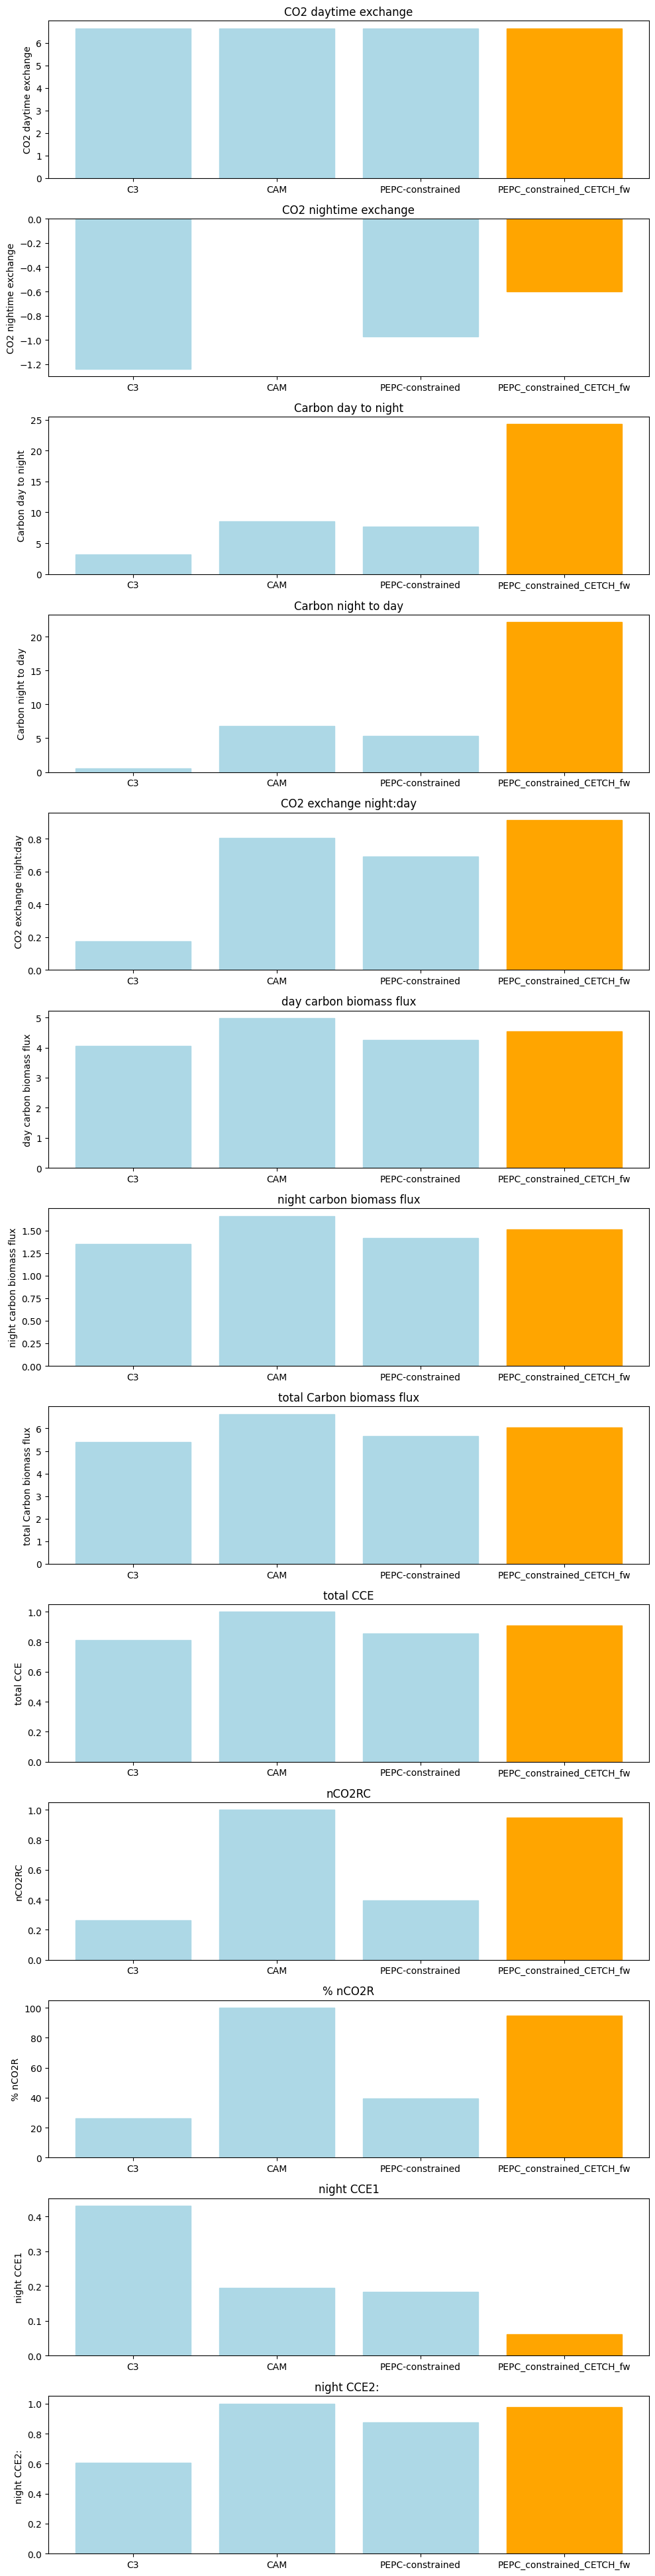

In [311]:
import matplotlib.pyplot as plt
import pandas as pd


# create a list of labels for the x-axis
labels = df_name_list

# create a DataFrame
df = pd.DataFrame()

# create a list of data for the y-axis and add it to the DataFrame
for i, model in enumerate(models):
    new_col = calc_carbon_flux(model,"AraCore_Biomass_tx")
    df.insert(i, labels[i], new_col)


# create a subplot for each row in the DataFrame
fig, axs = plt.subplots(df.shape[0], figsize=(10, df.shape[0]*3))

# plot bars for each column in the DataFrame
for i, ax in enumerate(axs):
    bars = ax.bar(df.columns, df.iloc[i])
    ax.set_title(df.T.columns[i])
    ax.set_ylabel(df.T.columns[i])



    # set the color of the bars based on the label
    for bar, label in zip(bars, df.columns):
        if 'CETCH' in label:
            bar.set_color('orange')
        else:
            bar.set_color('lightblue')

# display the plots
plt.tight_layout()
plt.show()

In [312]:
df

,C3,CAM,PEPC-constrained,PEPC_constrained_CETCH_fw
CO2 daytime exchange,6.643522,6.643000e+00,6.643000,6.643000
CO2 nightime exchange,-1.235915,-1.787854e-15,-0.969988,-0.597409
Carbon day to night,3.137901,8.494275e+00,7.712411,24.281285
Carbon night to day,0.550084,6.833525e+00,5.324170,22.172479
CO2 exchange night:day,0.175303,8.044860e-01,0.690338,0.913151
day carbon biomass flux,4.055705,4.982250e+00,4.254759,4.534193
night carbon biomass flux,1.351902,1.660750e+00,1.418253,1.511398
total Carbon biomass flux,5.407607,6.643000e+00,5.673012,6.045591
total CCE,0.813967,1.000000e+00,0.853983,0.910069
nCO2RC,0.263605,1.000000e+00,0.394973,0.947397


In [313]:
df_C2, sol_C2 = parameter_scan_CO2(CAM_constrained_CETCH_model_fw, "AraCore_Biomass_tx_total", "CO2_tx_00", 0, 17, 1, pFBA=True, 
                    CO2_refixation_allowed=True, verbose=True, iterations=50, 
                    double_ub = False, m=0.01025582745716949, b =-0.01170011252656307)

Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0088841
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.019403
producing HCO3-:	RXN0_5224_c_12	0.019403
producing CO2:	CO2_pc_12	0.231355
consuming CO2:	ISOCITDEH_RXN_c_12	-7.289963
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.002521
producing CO2:	CO2_mc_12	14.164884
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.019403
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.000527
consuming CO2:	RXN_8957_c_12	6.859695
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00057
producing CO2:	RXN_9652_p_12	0.001713
producing CO2:	RXN_9650_p_12	0.001713
producing CO2:	RXN_5682_p_12	0.000367
producing CO2:	2.3.1.180_RXN_p_12	0.001713
producing CO2:	RXN_9654_p_12	0.001713
consumin

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 3      Scan value: 2 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0196754
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.042971
producing HCO3-:	RXN0_5224_c_12	0.042971
producing CO2:	CO2_pc_12	0.258911
consuming CO2:	ISOCITDEH_RXN_c_12	-6.672594
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.005583
producing CO2:	CO2_mc_12	12.972946
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.042971
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.001168
consuming CO2:	RXN_8957_c_12	6.227842
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001261
producing CO2:	RXN_9652_p_12	0.003793
producing CO2:	RXN_9650_p_12	0.003793
producing CO2:	RXN_5682_p_12	0.000814
producing CO2:	2.3.1.180_RXN_p_12	0.003793
producing CO2:	RXN_9654_p_12	0.003793
consuming CO2:	RXN0_5224_p_12	0.026552
producing HCO3-:	RXN0_5224_p_12	0.026552
consuming CO2:	CO2_pc_12	0.258911
producing CO2:	1.2.1.2_RXN_p_12	0.000629
consuming HCO3-

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 4      Scan value: 3 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0304653
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.066536
producing HCO3-:	RXN0_5224_c_12	0.066536
producing CO2:	CO2_pc_12	0.286187
consuming CO2:	ISOCITDEH_RXN_c_12	-6.054823
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.008644
producing CO2:	CO2_mc_12	11.780598
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.066536
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.001808
consuming CO2:	RXN_8957_c_12	5.595589
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.001953
producing CO2:	RXN_9652_p_12	0.005873
producing CO2:	RXN_9650_p_12	0.005873
producing CO2:	RXN_5682_p_12	0.00126
producing CO2:	2.3.1.180_RXN_p_12	0.005873
producing CO2:	RXN_9654_p_12	0.005873
consuming CO2:	RXN0_5224_p_12	0.041113
producing HCO3-:	RXN0_5224_p_12	0.041113
consuming CO2:	CO2_pc_12	0.286187
producing CO2:	1.2.1.2_RXN_p_12	0.000973
consuming HCO3-:

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 5      Scan value: 4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0412553
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.090102
producing HCO3-:	RXN0_5224_c_12	0.090102
producing CO2:	CO2_pc_12	0.313463
consuming CO2:	ISOCITDEH_RXN_c_12	-5.437052
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.011706
producing CO2:	CO2_mc_12	10.58825
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.090102
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.002448
consuming CO2:	RXN_8957_c_12	4.963336
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.002645
producing CO2:	RXN_9652_p_12	0.007954
producing CO2:	RXN_9650_p_12	0.007954
producing CO2:	RXN_5682_p_12	0.001706
producing CO2:	2.3.1.180_RXN_p_12	0.007954
producing CO2:	RXN_9654_p_12	0.007954
consuming CO2:	RXN0_5224_p_12	0.055675
producing HCO3-:	RXN0_5224_p_12	0.055675
consuming CO2:	CO2_pc_12	0.313463
producing CO2:	1.2.1.2_RXN_p_12	0.001318
consuming HCO3-:

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 6      Scan value: 5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0520452
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.113667
producing HCO3-:	RXN0_5224_c_12	0.113667
producing CO2:	CO2_pc_12	0.34074
consuming CO2:	ISOCITDEH_RXN_c_12	-4.819281
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.014767
producing CO2:	CO2_mc_12	9.395902
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.113667
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.003089
consuming CO2:	RXN_8957_c_12	4.331083
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.003337
producing CO2:	RXN_9652_p_12	0.010034
producing CO2:	RXN_9650_p_12	0.010034
producing CO2:	RXN_5682_p_12	0.002152
producing CO2:	2.3.1.180_RXN_p_12	0.010034
producing CO2:	RXN_9654_p_12	0.010034
consuming CO2:	RXN0_5224_p_12	0.070236
producing HCO3-:	RXN0_5224_p_12	0.070236
consuming CO2:	CO2_pc_12	0.34074
producing CO2:	1.2.1.2_RXN_p_12	0.001663
consuming HCO3-:	A

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 7      Scan value: 6 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0628352
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.137232
producing HCO3-:	RXN0_5224_c_12	0.137232
producing CO2:	CO2_pc_12	0.368016
consuming CO2:	ISOCITDEH_RXN_c_12	-4.20151
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.017829
producing CO2:	CO2_mc_12	8.203555
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.137232
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.003729
consuming CO2:	RXN_8957_c_12	3.69883
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004028
producing CO2:	RXN_9652_p_12	0.012114
producing CO2:	RXN_9650_p_12	0.012114
producing CO2:	RXN_5682_p_12	0.002598
producing CO2:	2.3.1.180_RXN_p_12	0.012114
producing CO2:	RXN_9654_p_12	0.012114
consuming CO2:	RXN0_5224_p_12	0.084797
producing HCO3-:	RXN0_5224_p_12	0.084797
consuming CO2:	CO2_pc_12	0.368016
producing CO2:	1.2.1.2_RXN_p_12	0.002007
consuming HCO3-:	A

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 8      Scan value: 7 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0736251
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.160797
producing HCO3-:	RXN0_5224_c_12	0.160797
producing CO2:	CO2_pc_12	0.395293
consuming CO2:	ISOCITDEH_RXN_c_12	-3.583739
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.02089
producing CO2:	CO2_mc_12	7.011207
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.160797
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.004369
consuming CO2:	RXN_8957_c_12	3.066577
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00472
producing CO2:	RXN_9652_p_12	0.014194
producing CO2:	RXN_9650_p_12	0.014194
producing CO2:	RXN_5682_p_12	0.003044
producing CO2:	2.3.1.180_RXN_p_12	0.014194
producing CO2:	RXN_9654_p_12	0.014194
consuming CO2:	RXN0_5224_p_12	0.099358
producing HCO3-:	RXN0_5224_p_12	0.099358
consuming CO2:	CO2_pc_12	0.395293
producing CO2:	1.2.1.2_RXN_p_12	0.002352
consuming HCO3-:	A

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 9      Scan value: 8 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0844151
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.184363
producing HCO3-:	RXN0_5224_c_12	0.184363
producing CO2:	CO2_pc_12	0.422569
consuming CO2:	ISOCITDEH_RXN_c_12	-2.965968
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.023952
producing CO2:	CO2_mc_12	5.818859
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.184363
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.00501
consuming CO2:	RXN_8957_c_12	2.434324
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005412
producing CO2:	RXN_9652_p_12	0.016274
producing CO2:	RXN_9650_p_12	0.016274
producing CO2:	RXN_5682_p_12	0.003491
producing CO2:	2.3.1.180_RXN_p_12	0.016274
producing CO2:	RXN_9654_p_12	0.016274
consuming CO2:	RXN0_5224_p_12	0.11392
producing HCO3-:	RXN0_5224_p_12	0.11392
consuming CO2:	CO2_pc_12	0.422569
producing CO2:	1.2.1.2_RXN_p_12	0.002697
consuming HCO3-:	AC

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 10      Scan value: 9 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0952051
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.207928
producing HCO3-:	RXN0_5224_c_12	0.207928
producing CO2:	CO2_pc_12	0.449846
consuming CO2:	ISOCITDEH_RXN_c_12	-2.348197
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.027013
producing CO2:	CO2_mc_12	4.626512
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.207928
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.00565
consuming CO2:	RXN_8957_c_12	1.802071
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006104
producing CO2:	RXN_9652_p_12	0.018354
producing CO2:	RXN_9650_p_12	0.018354
producing CO2:	RXN_5682_p_12	0.003937
producing CO2:	2.3.1.180_RXN_p_12	0.018354
producing CO2:	RXN_9654_p_12	0.018354
consuming CO2:	RXN0_5224_p_12	0.128481
producing HCO3-:	RXN0_5224_p_12	0.128481
consuming CO2:	CO2_pc_12	0.449846
producing CO2:	1.2.1.2_RXN_p_12	0.003042
consuming HCO3-:

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 11      Scan value: 10 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.105995
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.231493
producing HCO3-:	RXN0_5224_c_12	0.231493
producing CO2:	CO2_pc_12	0.477122
consuming CO2:	ISOCITDEH_RXN_c_12	-1.730426
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.030075
producing CO2:	CO2_mc_12	3.434164
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.231493
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.00629
consuming CO2:	RXN_8957_c_12	1.169818
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006795
producing CO2:	RXN_9652_p_12	0.020435
producing CO2:	RXN_9650_p_12	0.020435
producing CO2:	RXN_5682_p_12	0.004383
producing CO2:	2.3.1.180_RXN_p_12	0.020435
producing CO2:	RXN_9654_p_12	0.020435
consuming CO2:	RXN0_5224_p_12	0.143042
producing HCO3-:	RXN0_5224_p_12	0.143042
consuming CO2:	CO2_pc_12	0.477122
producing CO2:	1.2.1.2_RXN_p_12	0.003386
consuming HCO3-:

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 12      Scan value: 11 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.116785
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.255058
producing HCO3-:	RXN0_5224_c_12	0.255058
producing CO2:	CO2_pc_12	0.504398
consuming CO2:	ISOCITDEH_RXN_c_12	-1.112655
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.033136
producing CO2:	CO2_mc_12	2.241816
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.255058
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.006931
consuming CO2:	RXN_8957_c_12	0.537566
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007487
producing CO2:	RXN_9652_p_12	0.022515
producing CO2:	RXN_9650_p_12	0.022515
producing CO2:	RXN_5682_p_12	0.004829
producing CO2:	2.3.1.180_RXN_p_12	0.022515
producing CO2:	RXN_9654_p_12	0.022515
consuming CO2:	RXN0_5224_p_12	0.157603
producing HCO3-:	RXN0_5224_p_12	0.157603
consuming CO2:	CO2_pc_12	0.504398
producing CO2:	1.2.1.2_RXN_p_12	0.003731
consuming HCO3-

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 13      Scan value: 12 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1271837
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.277769
producing HCO3-:	RXN0_5224_c_12	0.277769
producing CO2:	CO2_pc_12	0.523993
consuming CO2:	ISOCITDEH_RXN_c_12	-0.370539
consuming CO2:	CO2_xc_12	-0.109254
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036087
producing CO2:	CO2_mc_12	0.915721
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.248941
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.277769
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005259
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.007548
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.008154
producing CO2:	RXN_9652_p_12	0.02452
producing CO2:	RXN_9650_p_12	0.02452
producing CO2:	2.3.1.180_RXN_p_12	0.02452
producing CO2:	RXN_9654_p_12	0.02452
consuming CO2:	RXN0_5224_p_12	0.171637
producing HCO3-:	RXN0_5224_p_12	0.171637
consuming CO2:	CO2_p

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 14      Scan value: 13 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1285206
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.059121
producing HCO3-:	RXN0_5224_c_12	0.059121
producing CO2:	CO2_pc_12	0.552042
consuming CO2:	ISOCITDEH_RXN_c_12	-0.316529
consuming CO2:	CO2_xc_12	-0.11081
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036466
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012384
producing CO2:	CO2_mc_12	0.750613
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.361461
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.059121
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005314
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.007627
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024777
producing CO2:	RXN_9650_p_12	0.024777
producing CO2:	2.3.1.180_RXN_p_12	0.024777
producing CO2:	RXN_9654_p_12	0.024777
consuming CO2:	RXN0_5224_p_12	0.173441
producing HCO3-:	RXN0_5224_p_12	0.173441
consuming CO2:	CO2_pc

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 15      Scan value: 14 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1285206
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.059121
producing HCO3-:	RXN0_5224_c_12	0.059121
producing CO2:	CO2_pc_12	0.552042
consuming CO2:	ISOCITDEH_RXN_c_12	-0.316529
consuming CO2:	CO2_xc_12	-0.11081
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036466
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012384
producing CO2:	CO2_mc_12	0.750613
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.361461
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.059121
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005314
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.007627
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024777
producing CO2:	RXN_9650_p_12	0.024777
producing CO2:	2.3.1.180_RXN_p_12	0.024777
producing CO2:	RXN_9654_p_12	0.024777
consuming CO2:	RXN0_5224_p_12	0.173441
producing HCO3-:	RXN0_5224_p_12	0.173441
consuming CO2:	CO2_pc

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 16      Scan value: 15 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1285206
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.059121
producing HCO3-:	RXN0_5224_c_12	0.059121
producing CO2:	CO2_pc_12	0.552042
consuming CO2:	ISOCITDEH_RXN_c_12	-0.316529
consuming CO2:	CO2_xc_12	-0.11081
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036466
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012384
producing CO2:	CO2_mc_12	0.750613
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.361461
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.059121
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005314
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.007627
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024777
producing CO2:	RXN_9650_p_12	0.024777
producing CO2:	2.3.1.180_RXN_p_12	0.024777
producing CO2:	RXN_9654_p_12	0.024777
consuming CO2:	RXN0_5224_p_12	0.173441
producing HCO3-:	RXN0_5224_p_12	0.173441
consuming CO2:	CO2_pc

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 17      Scan value: 16 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1285206
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.059121
producing HCO3-:	RXN0_5224_c_12	0.059121
producing CO2:	CO2_pc_12	0.552042
consuming CO2:	ISOCITDEH_RXN_c_12	-0.316529
consuming CO2:	CO2_xc_12	-0.11081
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036466
producing CO2:	GLUTDECARBOX_RXN_c_12	0.012384
producing CO2:	CO2_mc_12	0.750613
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.361461
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.059121
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005314
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.007627
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024777
producing CO2:	RXN_9650_p_12	0.024777
producing CO2:	2.3.1.180_RXN_p_12	0.024777
producing CO2:	RXN_9654_p_12	0.024777
consuming CO2:	RXN0_5224_p_12	0.173441
producing HCO3-:	RXN0_5224_p_12	0.173441
consuming CO2:	CO2_pc

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


In [314]:
df_name_list

['C3', 'CAM', 'PEPC-constrained', 'PEPC_constrained_CETCH_fw']

0.0 0.0
9.97098523306073e-05 -0.0010150537053587845
0.043263457904943306 -1.0308394652854318
0.5887432056122325 -7.553432488099415
0.024704951262682 0.4912686886060906
-0.5568643915805174 7.491581030931644
0.0 0.0
0.0 0.0


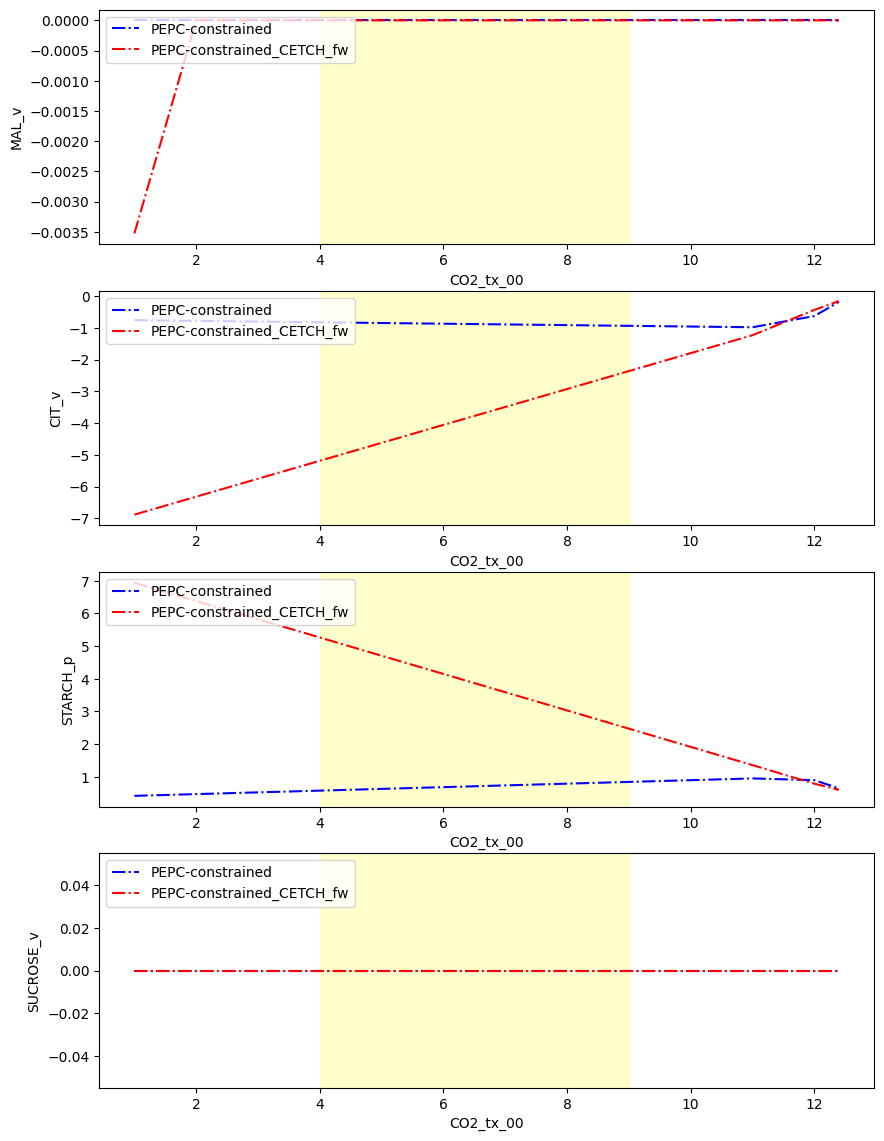

In [315]:
df_list = [df_C1, df_C2]
names = ["PEPC-constrained", "PEPC-constrained_CETCH_fw"]
x_axis = "CO2_tx_00"
y_axes = ["MAL_v_linker_12_to_00", "CIT_v_linker_12_to_00", "STARCH_p_linker_00_to_12", "SUCROSE_v_linker_00_to_12"]

import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(nrows=len(y_axes), ncols=1, figsize=(10, 14))
colors = ['blue','red','green']


for count, y_axis in enumerate(y_axes):
    
    
    for df, df_name in zip(df_list, names):
        # Assign colors to lines based on dataframe index
        color_index = names.index(df_name)
        color = colors[color_index % len(colors)]
    
        x1 = df.T[x_axis]
        x1 = x1.dropna()

        
        y1 = df.T[y_axis]
        y1 = y1.dropna()

        axs[count].plot(x1, y1, color=color, label=df_name, linestyle ="dashdot")

        # Calculate slope using linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x1, y1)

        print(slope, intercept)

    axs[count].set_xlabel(x_axis)
    axs[count].set_ylabel(y_axis.replace("_linker_00_to_12", "").replace("_linker_12_to_00", ""))
    axs[count].legend(loc='upper left')
    # Highlight the region between 4 and 9 on the x-axis
    axs[count].axvspan(4, 9, alpha=0.2, color='yellow')

plt.legend(loc='upper left')
plt.show()


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarnin

CO2 daytime exchange: 6.643522352606437
CO2 nightime exchange: -1.2359151744723074
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 3.1379011228183975
Carbon night to day: 0.550084153812556
CO2 exchange night:day: 0.17530321456352388
AraCore_Biomass_tx_00 carbon flux: -4.05570538360061
AraCore_Biomass_tx_12 carbon flux: -1.3519017945335363
total carbon biomass flux: -5.407607178134146
total CCE: 0.8139668824945816
nCO2RC: 0.26360495584536014
night CCE1 (carbon in to biomass): 0.4308299534050602
night CCE2 (1 - (carbon lost / carbon in)): 0.6061331679685834
CO2 daytime exchange: 6.643
CO2 nightime exchange: -1.7878542041230546e-15
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 8.49427505332916
Carbon night to day: 6.833525053329159
CO2 exchange night:day: 0.80448596383171
AraCore_Biomass_tx_00 carbon flux: -4.982249999999985
AraCore_Biomass_tx_12 carbon flux: -1.660749999999995
total carbon biomass flux: -6.64299999999998
total CCE: 0.99999999999999

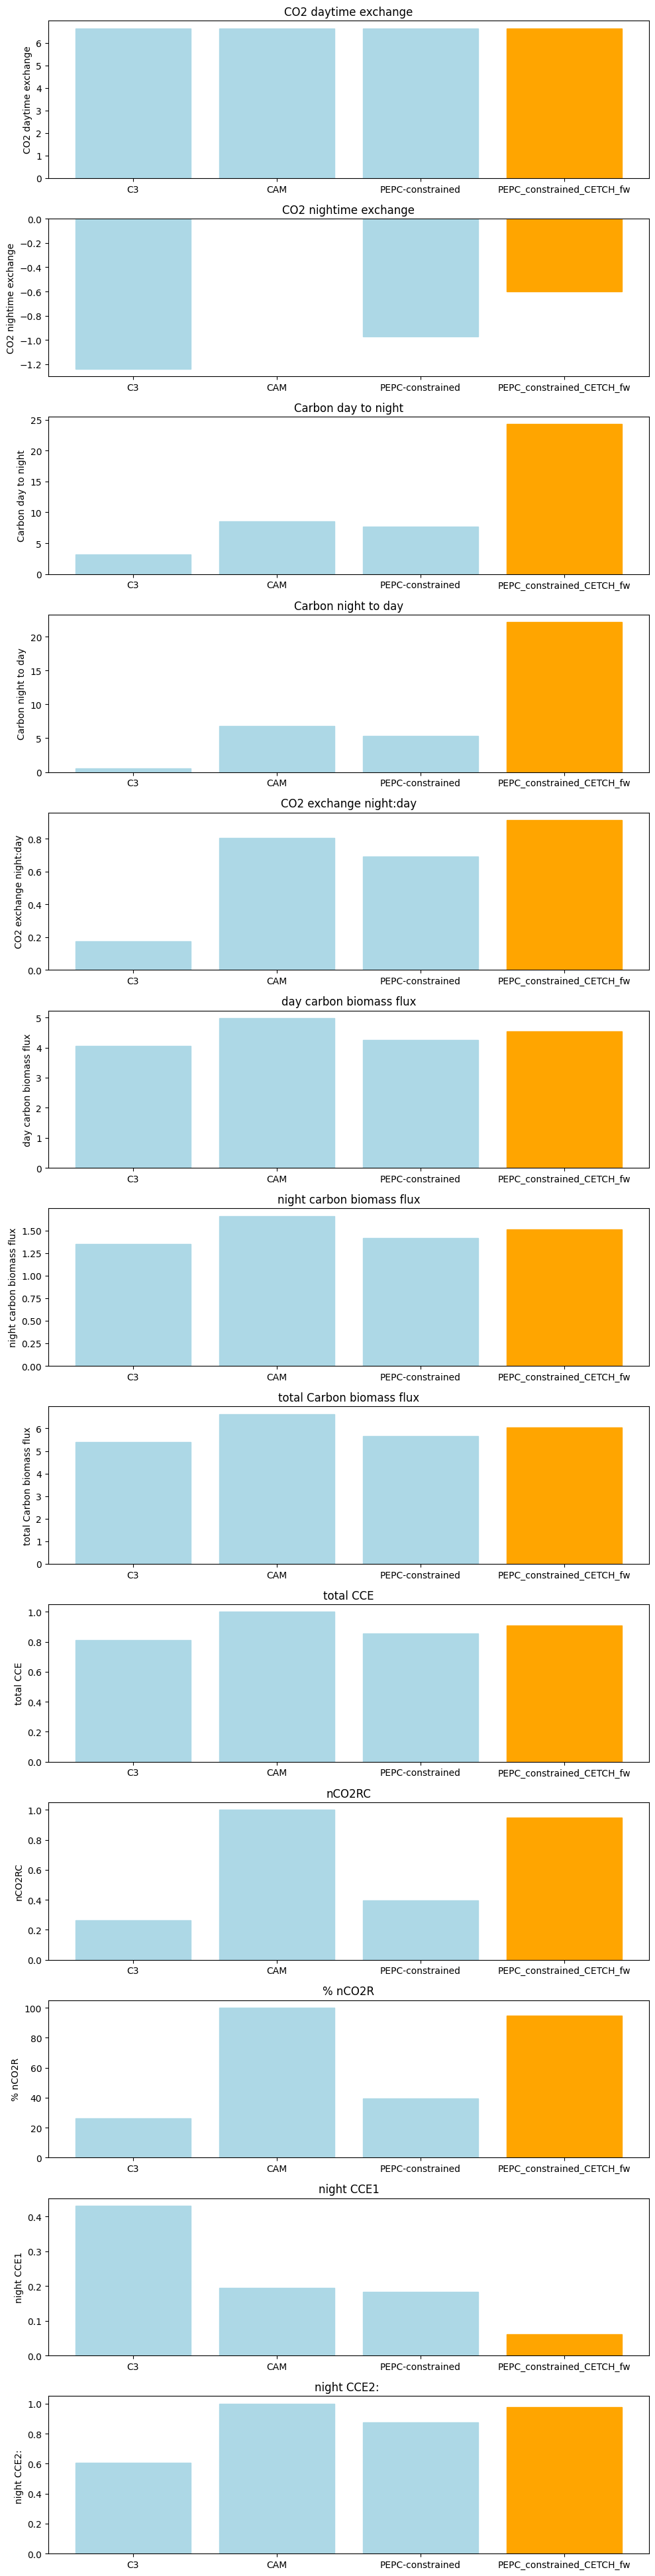

In [316]:
import matplotlib.pyplot as plt
import pandas as pd


# create a list of labels for the x-axis
labels = df_name_list

# create a DataFrame
df = pd.DataFrame()

# create a list of data for the y-axis and add it to the DataFrame
for i, model in enumerate(models):
    new_col = calc_carbon_flux(model,"AraCore_Biomass_tx")
    df.insert(i, labels[i], new_col)


# create a subplot for each row in the DataFrame
fig, axs = plt.subplots(df.shape[0], figsize=(10, df.shape[0]*3))

# plot bars for each column in the DataFrame
for i, ax in enumerate(axs):
    bars = ax.bar(df.columns, df.iloc[i])
    ax.set_title(df.T.columns[i])
    ax.set_ylabel(df.T.columns[i])



    # set the color of the bars based on the label
    for bar, label in zip(bars, df.columns):
        if 'CETCH' in label:
            bar.set_color('orange')
        else:
            bar.set_color('lightblue')

# display the plots
plt.tight_layout()
plt.show()

In [317]:
create_dataframe(df_name_list, solutions, models)

CO2 daytime exchange: 6.643522352606437
CO2 nightime exchange: -1.2359151744723074
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 3.1379011228183975
Carbon night to day: 0.550084153812556
CO2 exchange night:day: 0.17530321456352388
AraCore_Biomass_tx_00 carbon flux: -4.05570538360061
AraCore_Biomass_tx_12 carbon flux: -1.3519017945335363
total carbon biomass flux: -5.407607178134146
total CCE: 0.8139668824945816
nCO2RC: 0.26360495584536014
night CCE1 (carbon in to biomass): 0.4308299534050602
night CCE2 (1 - (carbon lost / carbon in)): 0.6061331679685834
CO2 daytime exchange: 6.643
CO2 nightime exchange: -1.7878542041230546e-15
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 8.49427505332916
Carbon night to day: 6.833525053329159
CO2 exchange night:day: 0.80448596383171
AraCore_Biomass_tx_00 carbon flux: -4.982249999999985
AraCore_Biomass_tx_12 carbon flux: -1.660749999999995
total carbon biomass flux: -6.64299999999998
total CCE: 0.99999999999999

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarnin

,C3,CAM,PEPC-constrained,PEPC_constrained_CETCH_fw
% nCO2R,26.360496,1.000000e+02,39.497327,94.739744
CIT_v_linker_12_to_00,0.086600,5.877512e-01,0.887362,3.695413
CO2 daytime exchange,6.643522,6.643000e+00,6.643000,6.643000
CO2 exchange night:day,0.175303,8.044860e-01,0.690338,0.913151
CO2 nightime exchange,-1.235915,-1.787854e-15,-0.969988,-0.597409
Carbon day to night,3.137901,8.494275e+00,7.712411,24.281285
Carbon night to day,0.550084,6.833525e+00,5.324170,22.172479
MAL_v_linker_12_to_00,0.000000,8.267544e-01,0.000000,0.000000
Photon flux,111.328905,1.391162e+02,122.340179,200.000000
Rubisco flux,7.929695,9.792442e+00,8.487373,14.191300


In [318]:
# df.to_csv("CETCH_fluxes.csv")

## exchanging NADPH for NADH in the CETCH cycle, restricted to one direction

In [319]:

cetch_model_NADH = cobra.io.read_sbml_model("CETCH_cycle.xml")
# remove vinylacetyl-CoA (CPD_226), as it is an intermediate that is not included in any reactions
cetch_model_NADH.remove_metabolites([cetch_model_NADH.metabolites.CPD_226])

'' is not a valid SBML 'SId'.
https://identifiers.org/Enzyme Commission Summary/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
No objective coefficients in model. Unclear what should be optimized


In [320]:
for rxn in cetch_model_NADH.reactions:
    print(rxn)


MALSYN_RXN: ACETYL_COA + GLYOX + WATER --> CO_A + MAL + PROTON
RXN_8961: CPD_9409 <=> GLYOX + PROPIONYL_COA
RXN_15977: OXYGEN_MOLECULE + PROPIONYL_COA <=> ACRYLYL_COA + HYDROGEN_PEROXIDE
RXN_18384: ACRYLYL_COA + CARBON_DIOXIDE + NADPH <=> METHYL_MALONYL_COA + NADP
METHYLMALONYL_COA_MUT_RXN: METHYL_MALONYL_COA <=> SUC_COA
RXN_8891: CO_A + NADP + SUCC_S_ALD <=> NADPH + PROTON + SUC_COA
RXN_11002: NADPH + PROTON + SUCC_S_ALD <=> 4_HYDROXY_BUTYRATE + NADP
RXN_18387: 4_HYDROXY_BUTYRATE + ATP + CO_A <=> 4_HYDROXY_BUTYRYL_COA + ADP + Pi
RXN_8890: 4_HYDROXY_BUTYRYL_COA <=> CROTONYL_COA + WATER
RXN_8957: CARBON_DIOXIDE + CROTONYL_COA + NADPH <=> CPD_9406 + NADP
RXN_16391: CPD_9406 <=> CPD_17635
RXN_8958: CPD_17635 <=> CPD_9407
RXN_18381: CPD_9407 + OXYGEN_MOLECULE <=> CPD_9408 + HYDROGEN_PEROXIDE
RXN_8960: CPD_9409 <=> CPD_9408 + WATER


In [321]:
NADH_met = Metabolite("NADH", name="NADH", compartment="u", charge = -2, formula = "C21H27N7O14P2")
NADH_met.annotation = {'biocyc': 'META:NADH',
 'metacyc.compound': 'NADH',
 'bigg.metabolite': 'nadh',
 'chebi': 'CHEBI:16908',
 'hmdb': 'HMDB01487',
 'kegg': 'C00004',
 'reactome': '192305.0',
 'sabiork.compound': '38.0',
 'seed': 'cpd00004',
 'metanetx.chemical': 'MNXM89564',
 'synonyms': 'Nicotinamide adenine dinucleotide - reduced',
 'inchi': 'InChI=1/C21H29N7O14P2/c22-17-12-19(25-7-24-17)28(8-26-12)21-16(32)14(30)11(41-21)6-39-44(36,37)42-43(34,35)38-5-10-13(29)15(31)20(40-10)27-3-1-2-9(4-27)18(23)33/h1,3-4,7-8,10-11,13-16,20-21,29-32H,2,5-6H2,(H2,23,33)(H,34,35)(H,36,37)(H2,22,24,25)/p-2/fC21H27N7O14P2/h22-23H2/q-2'}

NAD_met = Metabolite("NAD", name="NAD", compartment="u", charge = -1, formula = "C21H26N7O14P2")
NAD_met.annotation ={'biocyc': 'META:NAD',
 'metacyc.compound': 'NAD',
 'bigg.metabolite': 'nad',
 'chebi': 'CHEBI:15846',
 'hmdb': 'HMDB00902',
 'kegg': 'C00003',
 'reactome': '113526.0',
 'sabiork.compound': '37.0',
 'seed': 'cpd00003',
 'metanetx.chemical': 'MNXM588016',
 'synonyms': 'Nicotinamide adenine dinucleotide',
 'inchi': 'InChI=1/C21H27N7O14P2/c22-17-12-19(25-7-24-17)28(8-26-12)21-16(32)14(30)11(41-21)6-39-44(36,37)42-43(34,35)38-5-10-13(29)15(31)20(40-10)27-3-1-2-9(4-27)18(23)33/h1-4,7-8,10-11,13-16,20-21,29-32H,5-6H2,(H5-,22,23,24,25,33,34,35,36,37)/p-1/t10-,11-,13-,14-,15-,16-,20-,21-/m1/s1/fC21H26N7O14P2/h22-23H2/q-1'}

cetch_model_NADH.add_metabolites([NADH_met, NAD_met])


for rxn in cetch_model_NADH.reactions:
    if "NADPH" in [met.id for met in rxn.metabolites]:
        print(rxn.id)
        rxn.add_metabolites({cetch_model_NADH.metabolites.NADH:rxn.get_coefficient(cetch_model_NADH.metabolites.NADPH)*1,
                             cetch_model_NADH.metabolites.NAD:rxn.get_coefficient(cetch_model_NADH.metabolites.NADP)*1})
        
        rxn.add_metabolites({cetch_model_NADH.metabolites.NADPH:rxn.get_coefficient(cetch_model_NADH.metabolites.NADPH)*-1,
                             cetch_model_NADH.metabolites.NADP:rxn.get_coefficient(cetch_model_NADH.metabolites.NADP)*-1})

RXN_18384
RXN_8891
RXN_11002
RXN_8957


In [322]:
for rxn in cetch_model_NADH.reactions:
    print(rxn)


MALSYN_RXN: ACETYL_COA + GLYOX + WATER --> CO_A + MAL + PROTON
RXN_8961: CPD_9409 <=> GLYOX + PROPIONYL_COA
RXN_15977: OXYGEN_MOLECULE + PROPIONYL_COA <=> ACRYLYL_COA + HYDROGEN_PEROXIDE
RXN_18384: ACRYLYL_COA + CARBON_DIOXIDE + NADH <=> METHYL_MALONYL_COA + NAD
METHYLMALONYL_COA_MUT_RXN: METHYL_MALONYL_COA <=> SUC_COA
RXN_8891: CO_A + NAD + SUCC_S_ALD <=> NADH + PROTON + SUC_COA
RXN_11002: NADH + PROTON + SUCC_S_ALD <=> 4_HYDROXY_BUTYRATE + NAD
RXN_18387: 4_HYDROXY_BUTYRATE + ATP + CO_A <=> 4_HYDROXY_BUTYRYL_COA + ADP + Pi
RXN_8890: 4_HYDROXY_BUTYRYL_COA <=> CROTONYL_COA + WATER
RXN_8957: CARBON_DIOXIDE + CROTONYL_COA + NADH <=> CPD_9406 + NAD
RXN_16391: CPD_9406 <=> CPD_17635
RXN_8958: CPD_17635 <=> CPD_9407
RXN_18381: CPD_9407 + OXYGEN_MOLECULE <=> CPD_9408 + HYDROGEN_PEROXIDE
RXN_8960: CPD_9409 <=> CPD_9408 + WATER


In [323]:
for rxn in cetch_model_NADH.reactions:
    print(rxn.bounds)

(0.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)
(-1000.0, 1000.0)


In [324]:
for item in cetch_dr_dict:
    cetch_model_NADH.reactions.get_by_id(item).bounds = cetch_dr_dict[item]
    
for rxn in cetch_model_NADH.reactions:
    print(rxn.bounds)

(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(-1000, 0)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(-1000, 0)


In [325]:
CAM_constrained_CETCH_model_fw_NADH = CAM_constrained_model.copy()

CAM_constrained_CETCH_model_fw_NADH, _ = add_pathway_to_compartments(CAM_constrained_CETCH_model_fw_NADH, 
                                            cetch_model_NADH, ["_12"], ["_p", "_c", "_m", "_x"], transporters=True, 
                                            linkers=False, charge_states=False, charge_states_dict={})

Ignoring reaction 'MALSYN_RXN_x_12' since it already exists.


In [326]:
for rxn in cetch_model_NADH.reactions:
    print(rxn.bounds)

(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(-1000, 0)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(0, 1000)
(-1000, 0)


In [327]:
solution_CAM_constrained_CETCH_model_fw_NADH, CAM_constrained_CETCH_model_fw_NADH_opt = optimise_model(CAM_constrained_CETCH_model_fw_NADH, "AraCore_Biomass_tx_total", pFBA=True)

Objective: AraCore_Biomass_tx_total


In [328]:
df_name_list.append('PEPC_constrained_CETCH_fw_NADH')

In [329]:
models.append(CAM_constrained_CETCH_model_fw_NADH_opt)

In [330]:
solutions.append(solution_CAM_constrained_CETCH_model_fw_NADH)

## Add CETCH (NADPH) cycle to day and night (carboxylases off during day)

In [331]:
CAM_constrained_CETCH_model_fw_day_night = CAM_constrained_model.copy()

CAM_constrained_CETCH_model_fw_day_night, _ = add_pathway_to_compartments(CAM_constrained_CETCH_model_fw_day_night, 
                                            cetch_model_fw, ["_00", "_12"], ["_p", "_c", "_m", "_x"], transporters=True, 
                                            linkers=True, charge_states=False, charge_states_dict={})

## constrain CETCH CO2-fixing reactions during the day
CAM_constrained_CETCH_model_fw_day_night.reactions.RXN_18384_p_00.bounds = (0, 0)
CAM_constrained_CETCH_model_fw_day_night.reactions.RXN_18384_x_00.bounds = (0, 0)
CAM_constrained_CETCH_model_fw_day_night.reactions.RXN_18384_m_00.bounds = (0, 0)
CAM_constrained_CETCH_model_fw_day_night.reactions.RXN_18384_c_00.bounds = (0, 0)

CAM_constrained_CETCH_model_fw_day_night.reactions.RXN_8957_p_00.bounds = (0, 0)
CAM_constrained_CETCH_model_fw_day_night.reactions.RXN_8957_x_00.bounds = (0, 0)
CAM_constrained_CETCH_model_fw_day_night.reactions.RXN_8957_m_00.bounds = (0, 0)
CAM_constrained_CETCH_model_fw_day_night.reactions.RXN_8957_c_00.bounds = (0, 0)



solution_CAM_constrained_CETCH_model_fw_day_night, CAM_constrained_CETCH_model_fw_day_night_opt = optimise_model(CAM_constrained_CETCH_model_fw_day_night, "AraCore_Biomass_tx_total", pFBA=True)

df_name_list.append('PEPC_constrained_CETCH_fw_day_night')
models.append(CAM_constrained_CETCH_model_fw_day_night_opt)
solutions.append(solution_CAM_constrained_CETCH_model_fw_day_night)


Ignoring reaction 'MALSYN_RXN_x_00' since it already exists.
Ignoring reaction 'MALSYN_RXN_x_12' since it already exists.


Objective: AraCore_Biomass_tx_total


In [332]:
solutions

[<Solution 739.094 at 0x7f56ffbf2ad0>,
 <Solution 972.062 at 0x7f56f9021de0>,
 <Solution 850.155 at 0x7f56f840ab30>,
 <Solution 1810.261 at 0x7f56f6b2af20>,
 <Solution 1191.325 at 0x7f56edda2e00>,
 <Solution 957.903 at 0x7f56ec1fef80>]

Total: 5.328326690790601
Total: 9.565654784990867
Total: 8.206794730702814
Total: 29.95663962814018
Total: 14.174031443155243
Total: 8.271452419431155


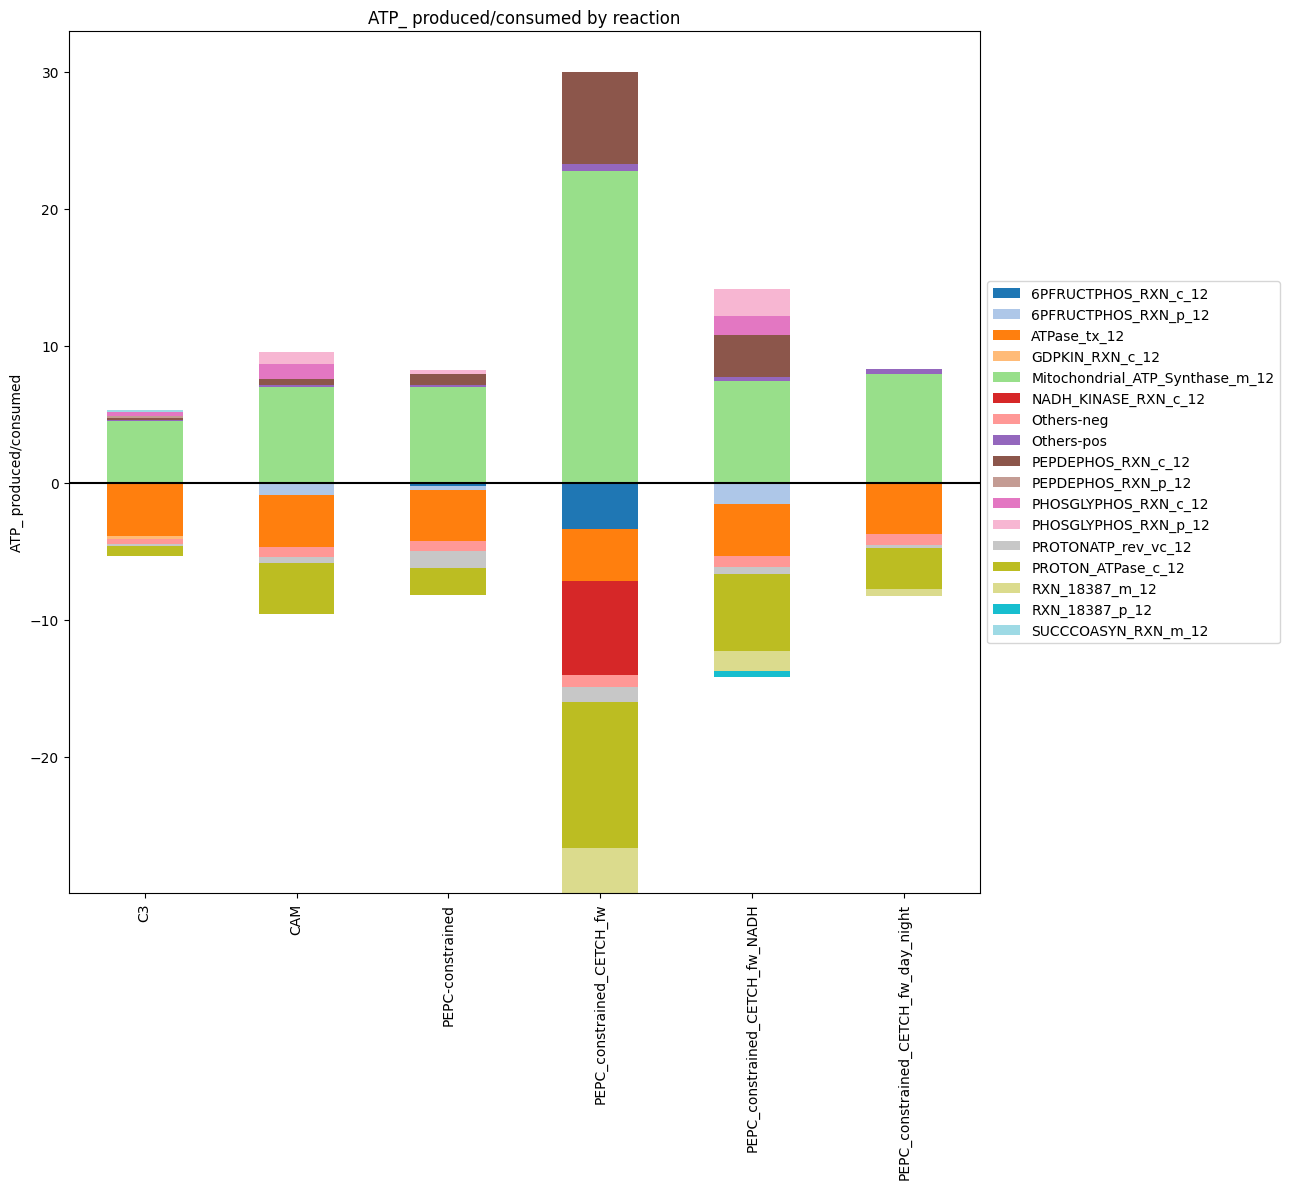

,C3,CAM,PEPC-constrained,PEPC_constrained_CETCH_fw,PEPC_constrained_CETCH_fw_NADH,PEPC_constrained_CETCH_fw_day_night
6PFRUCTPHOS_RXN_c_12,NaN,NaN,-0.242723,-3.393155,NaN,NaN
6PFRUCTPHOS_RXN_p_12,-0.106871,-0.903376,-0.265873,NaN,-1.583468,NaN
ATPase_tx_12,-3.765100,-3.765100,-3.765100,-3.765100,-3.765100,-3.765100
GDPKIN_RXN_c_12,-0.214159,NaN,NaN,NaN,NaN,NaN
Mitochondrial_ATP_Synthase_m_12,4.495512,7.005216,6.980046,22.793093,7.460031,7.968011
NADH_KINASE_RXN_c_12,NaN,NaN,NaN,-6.881977,NaN,NaN
Others-neg,-0.399336,-0.778732,-0.671786,-0.899295,-0.791417,-0.791417
Others-pos,0.091190,0.143153,0.121162,0.450616,0.270895,0.303441
PEPDEPHOS_RXN_c_12,0.133775,0.396864,0.822604,6.712930,3.061627,NaN
PEPDEPHOS_RXN_p_12,0.122815,NaN,NaN,NaN,NaN,NaN


In [333]:
plot_metabolite_budgets(df_name_list, models, solutions, "ATP_")


Total: 1.6783317382195342
Total: 1.9705533288939603
Total: 1.6032146843018775
Total: 11.357031166395245
Total: 4.525095274947562
Total: 2.105292891863693


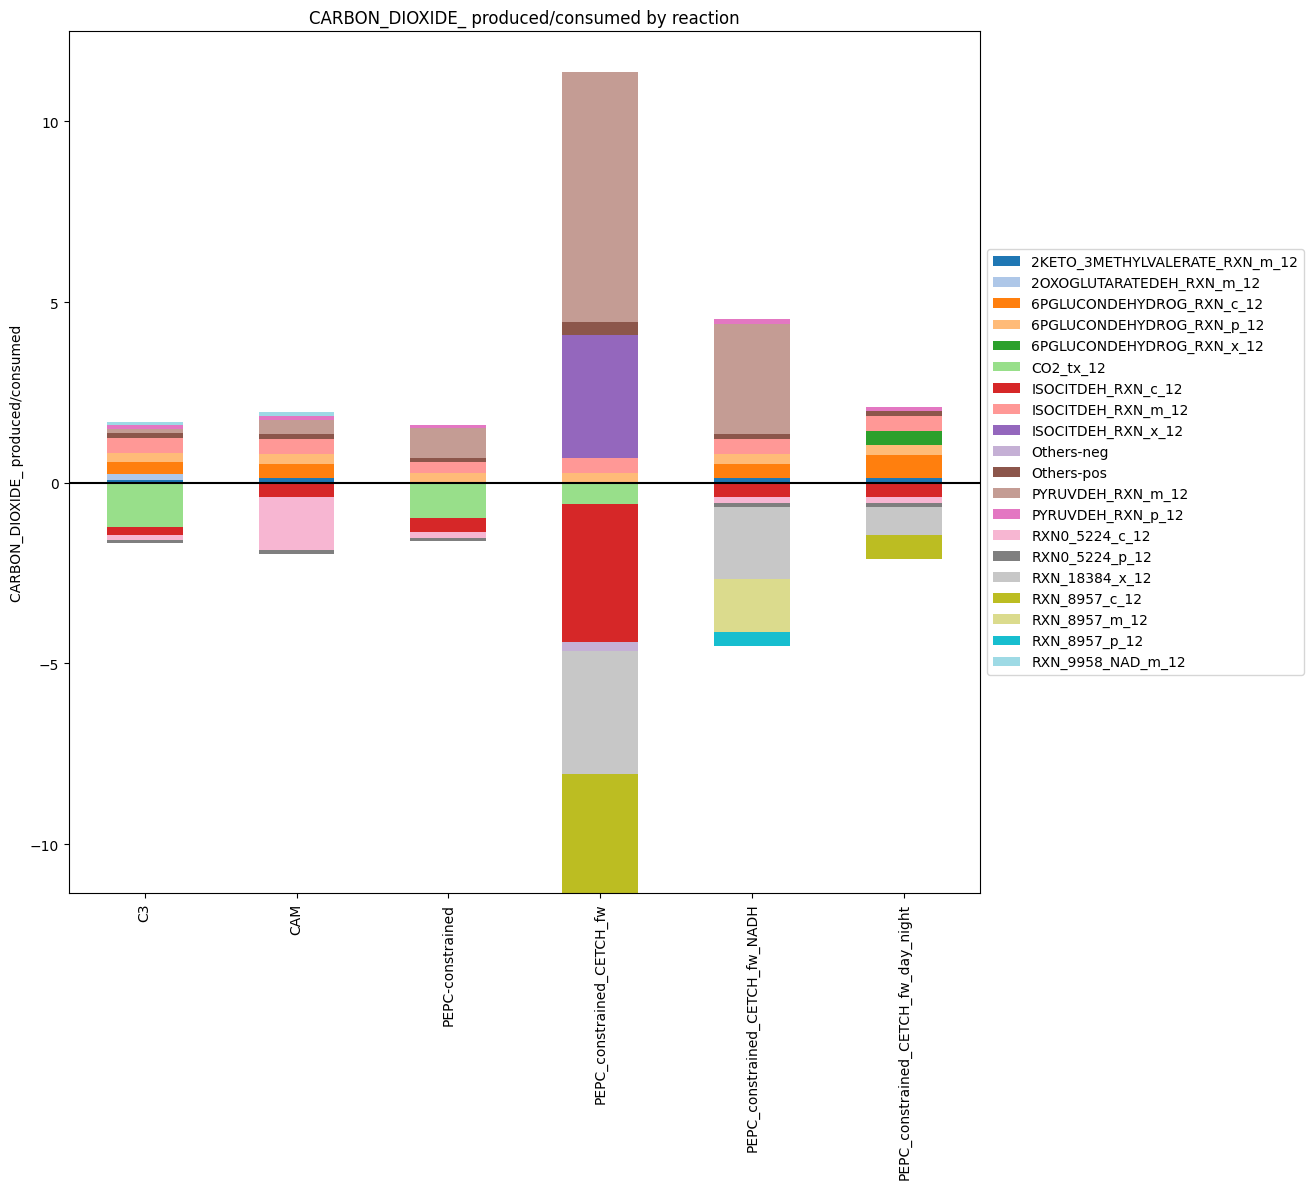

,C3,CAM,PEPC-constrained,PEPC_constrained_CETCH_fw,PEPC_constrained_CETCH_fw_NADH,PEPC_constrained_CETCH_fw_day_night
2KETO_3METHYLVALERATE_RXN_m_12,0.083819,0.120290,NaN,NaN,0.129016,0.129016
2OXOGLUTARATEDEH_RXN_m_12,0.170889,NaN,NaN,NaN,NaN,NaN
6PGLUCONDEHYDROG_RXN_c_12,0.319490,0.401194,NaN,NaN,0.399447,0.633516
6PGLUCONDEHYDROG_RXN_p_12,0.256522,0.267938,0.259694,0.267251,0.272301,0.272301
6PGLUCONDEHYDROG_RXN_x_12,NaN,NaN,NaN,NaN,NaN,0.392739
CO2_tx_12,-1.235915,NaN,-0.969988,-0.597409,NaN,NaN
ISOCITDEH_RXN_c_12,-0.221864,-0.391173,-0.397806,-3.804283,-0.387680,-0.387680
ISOCITDEH_RXN_m_12,0.418344,0.418344,0.313815,0.418344,0.418344,0.418344
ISOCITDEH_RXN_x_12,NaN,NaN,NaN,3.412165,NaN,NaN
Others-neg,0.000000,-0.004767,-0.004071,-0.250883,-0.004767,-0.004767


In [334]:
plot_metabolite_budgets(df_name_list, models, solutions, "CARBON_DIOXIDE_")

Total: 1.5715971166493234
Total: 1.763737467841502
Total: 1.7565896176889007
Total: 18.467399257875517
Total: 1.7689704892254468
Total: 3.2109091430685996


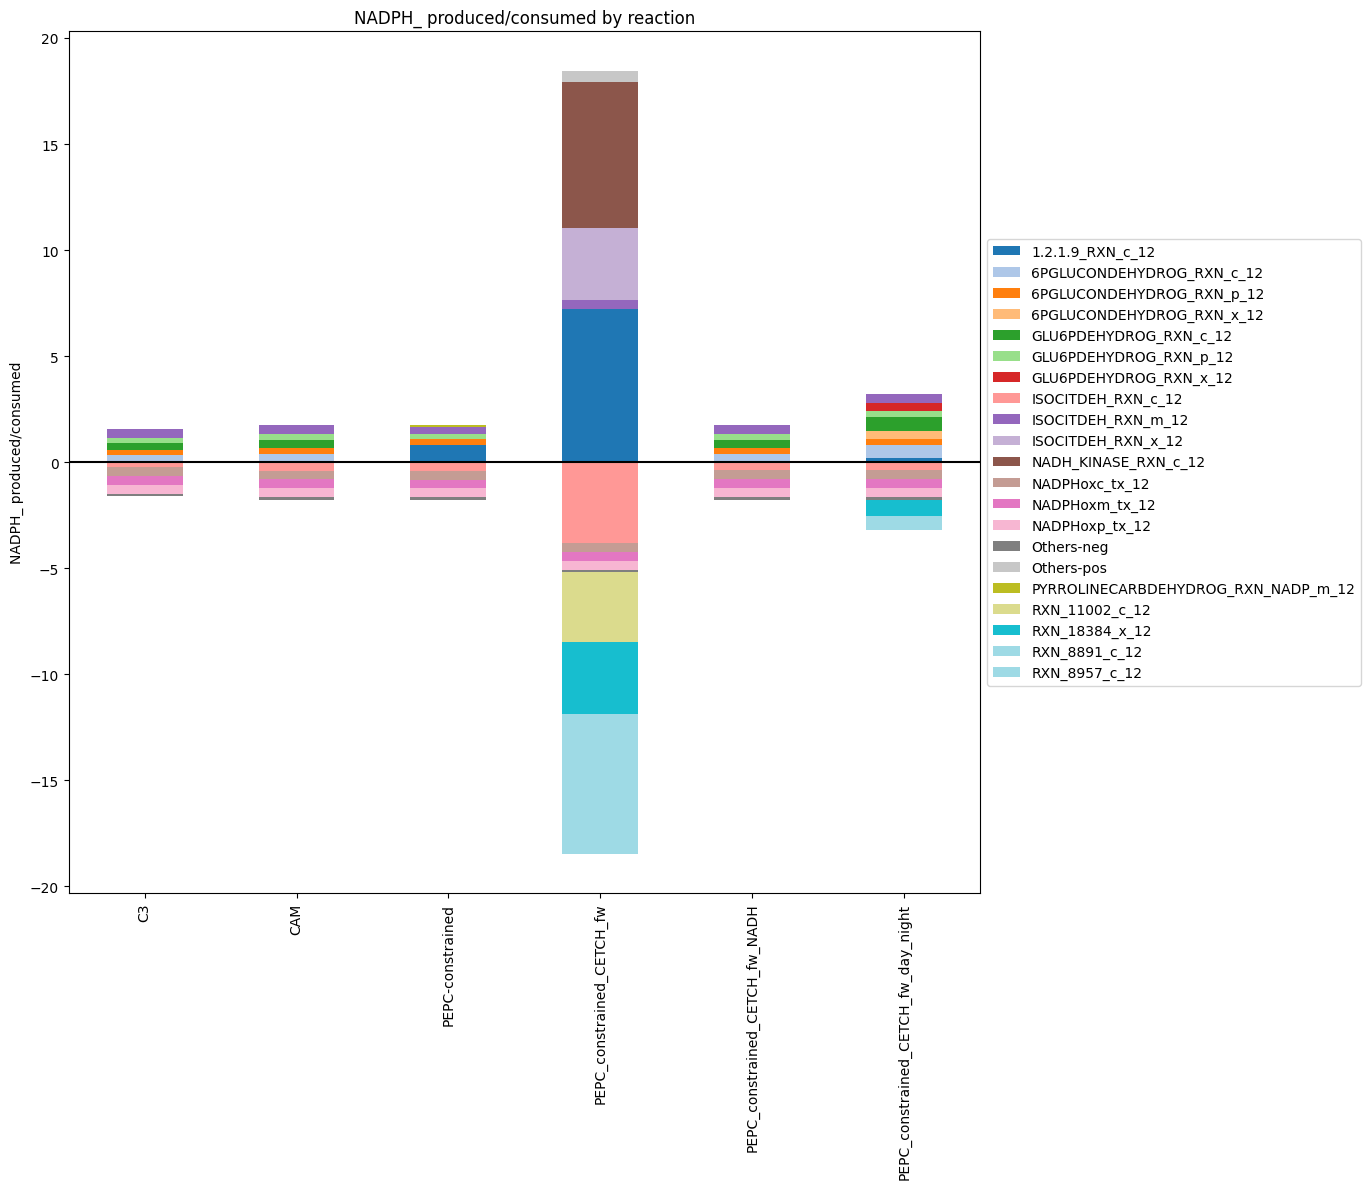

,C3,CAM,PEPC-constrained,PEPC_constrained_CETCH_fw,PEPC_constrained_CETCH_fw_NADH,PEPC_constrained_CETCH_fw_day_night
1.2.1.9_RXN_c_12,NaN,NaN,0.812769,7.213922,NaN,0.190773
6PGLUCONDEHYDROG_RXN_c_12,0.319490,0.401194,NaN,NaN,0.399447,0.633516
6PGLUCONDEHYDROG_RXN_p_12,0.256522,0.267938,0.259694,NaN,0.272301,0.272301
6PGLUCONDEHYDROG_RXN_x_12,NaN,NaN,NaN,NaN,NaN,0.392739
GLU6PDEHYDROG_RXN_c_12,0.319490,0.401194,NaN,NaN,0.399447,0.633516
GLU6PDEHYDROG_RXN_p_12,0.256522,0.267938,0.259694,NaN,0.272301,0.272301
GLU6PDEHYDROG_RXN_x_12,NaN,NaN,NaN,NaN,NaN,0.392739
ISOCITDEH_RXN_c_12,-0.221864,-0.391173,-0.397806,-3.804283,-0.387680,-0.387680
ISOCITDEH_RXN_m_12,0.418344,0.418344,0.313815,0.418344,0.418344,0.418344
ISOCITDEH_RXN_x_12,NaN,NaN,NaN,3.412165,NaN,NaN


In [335]:
plot_metabolite_budgets(df_name_list, models, solutions, "NADPH_")

In [336]:
diel_model.reactions.get_by_id("1.2.1.9_RXN_c_12")

Reaction identifier,1.2.1.9_RXN_c_12
Name,1.2.1.9-RXN:Glyceraldehyde-3-phosphate dehydrogenase (NADP+)
Memory address,0x7f57031bc8e0
Stoichiometry,GAP_c_12 + NADP_c_12 + WATER_c_12 --> G3P_c_12 + NADPH_c_12 + 2.0 PROTON_c_12 GAP + NADP + WATER --> G3P + NADPH + 2.0 PROTON
GPR,
Lower bound,0.0
Upper bound,1000.0


In [337]:
for rxn in diel_model.metabolites.GAP_c_12.reactions:
    print(rxn)

GAP_3PGA_pc_12: G3P_c_12 + GAP_p_12 + PROTON_c_12 <=> G3P_p_12 + GAP_c_12 + PROTON_p_12
TRIOSEPISOMERIZATION_RXN_c_12: GAP_c_12 <=> DIHYDROXY_ACETONE_PHOSPHATE_c_12
GAPOXNPHOSPHN_RXN_c_12: GAP_c_12 + NAD_c_12 + Pi_c_12 <=> DPG_c_12 + NADH_c_12 + 1.11 PROTON_c_12
GAP_Pi_pc_12: GAP_p_12 + Pi_c_12 <=> GAP_c_12 + 0.11 PROTON_c_12 + Pi_p_12
F16ALDOLASE_RXN_c_12: FRUCTOSE_16_DIPHOSPHATE_c_12 <=> DIHYDROXY_ACETONE_PHOSPHATE_c_12 + GAP_c_12
1.2.1.9_RXN_c_12: GAP_c_12 + NADP_c_12 + WATER_c_12 --> G3P_c_12 + NADPH_c_12 + 2.0 PROTON_c_12


In [338]:
diel_model.metabolites.G3P_c_12

Metabolite identifier,G3P_c_12
Name,G3P
Memory address,0x7f570c96f040
Formula,C3H4O7P1
Compartment,c_12
In 6 reaction(s),"GAP_3PGA_pc_12, 3PGA_Pi_pc_12, PHOSGLYPHOS_RXN_c_12, DHAP_3PGA_pc_12, 3PGAREARR_RXN_c_12, 1.2.1.9_RXN_c_12"


In [339]:
for rxn in diel_model.metabolites.DPG_c_12.reactions:
    print(rxn)

GAPOXNPHOSPHN_RXN_c_12: GAP_c_12 + NAD_c_12 + Pi_c_12 <=> DPG_c_12 + NADH_c_12 + 1.11 PROTON_c_12
PHOSGLYPHOS_RXN_c_12: ATP_c_12 + G3P_c_12 + 0.16 PROTON_c_12 <=> ADP_c_12 + DPG_c_12


Total: 9.067635544660657
Total: 10.438720443654178
Total: 9.471303425738109
Total: 14.819737580114385
Total: 11.680640519118596
Total: 10.560019198878159


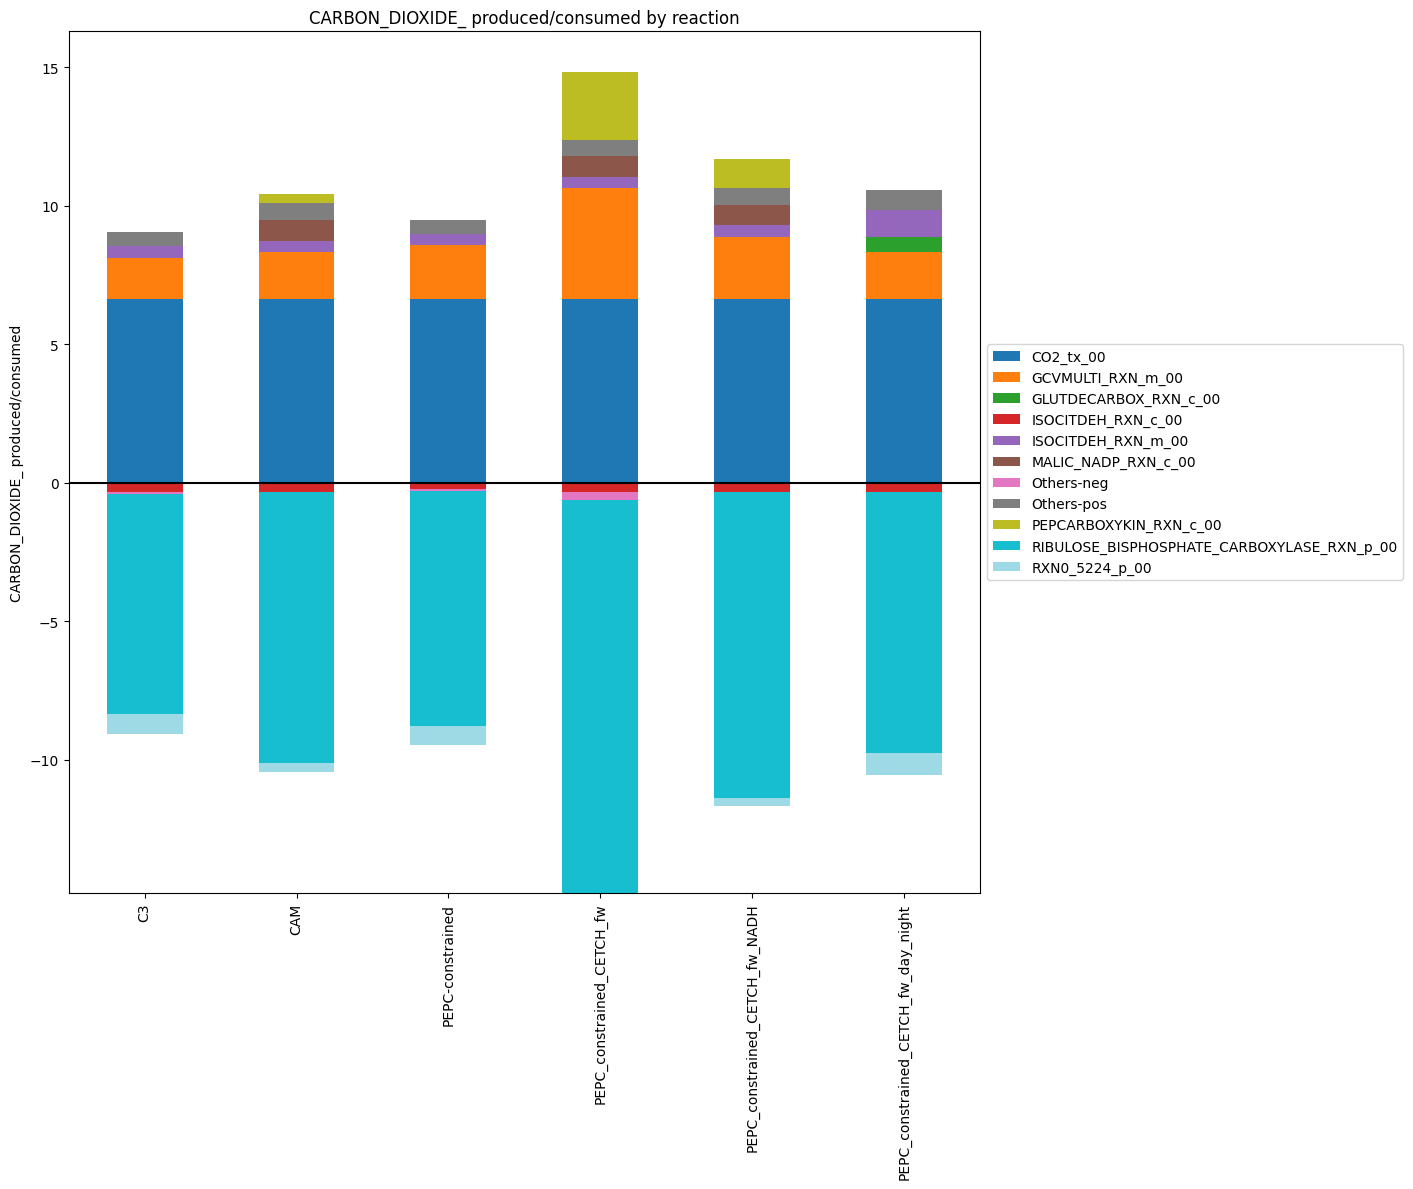

,C3,CAM,PEPC-constrained,PEPC_constrained_CETCH_fw,PEPC_constrained_CETCH_fw_NADH,PEPC_constrained_CETCH_fw_day_night
CO2_tx_00,6.643522,6.643000,6.643000,6.643000,6.643000,6.643000
GCVMULTI_RXN_m_00,1.473814,1.679334,1.928659,3.989815,2.229581,1.708009
GLUTDECARBOX_RXN_c_00,NaN,NaN,NaN,NaN,NaN,0.536836
ISOCITDEH_RXN_c_00,-0.344089,-0.321584,-0.229606,-0.332943,-0.326351,-0.326351
ISOCITDEH_RXN_m_00,0.418344,0.418344,0.418344,0.418344,0.418344,0.949639
MALIC_NADP_RXN_c_00,NaN,0.730655,NaN,0.738509,0.730655,NaN
Others-neg,-0.071070,-0.014301,-0.057650,-0.295495,-0.014301,-0.014301
Others-pos,0.531955,0.629638,0.481300,0.580956,0.638364,0.722535
PEPCARBOXYKIN_RXN_c_00,NaN,0.337750,NaN,2.449113,1.020696,NaN
RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_00,-7.929695,-9.792442,-8.487373,-14.191300,-11.029595,-9.432019


In [541]:
plot_metabolite_budgets(df_name_list, models, solutions, "CARBON_DIOXIDE_", tag= "_00")

Total: 2.332462091381153
Total: 3.0517106579133113
Total: 2.6142169541581692
Total: 5.289453693544596
Total: 3.615451318615823
Total: 3.343667526361873


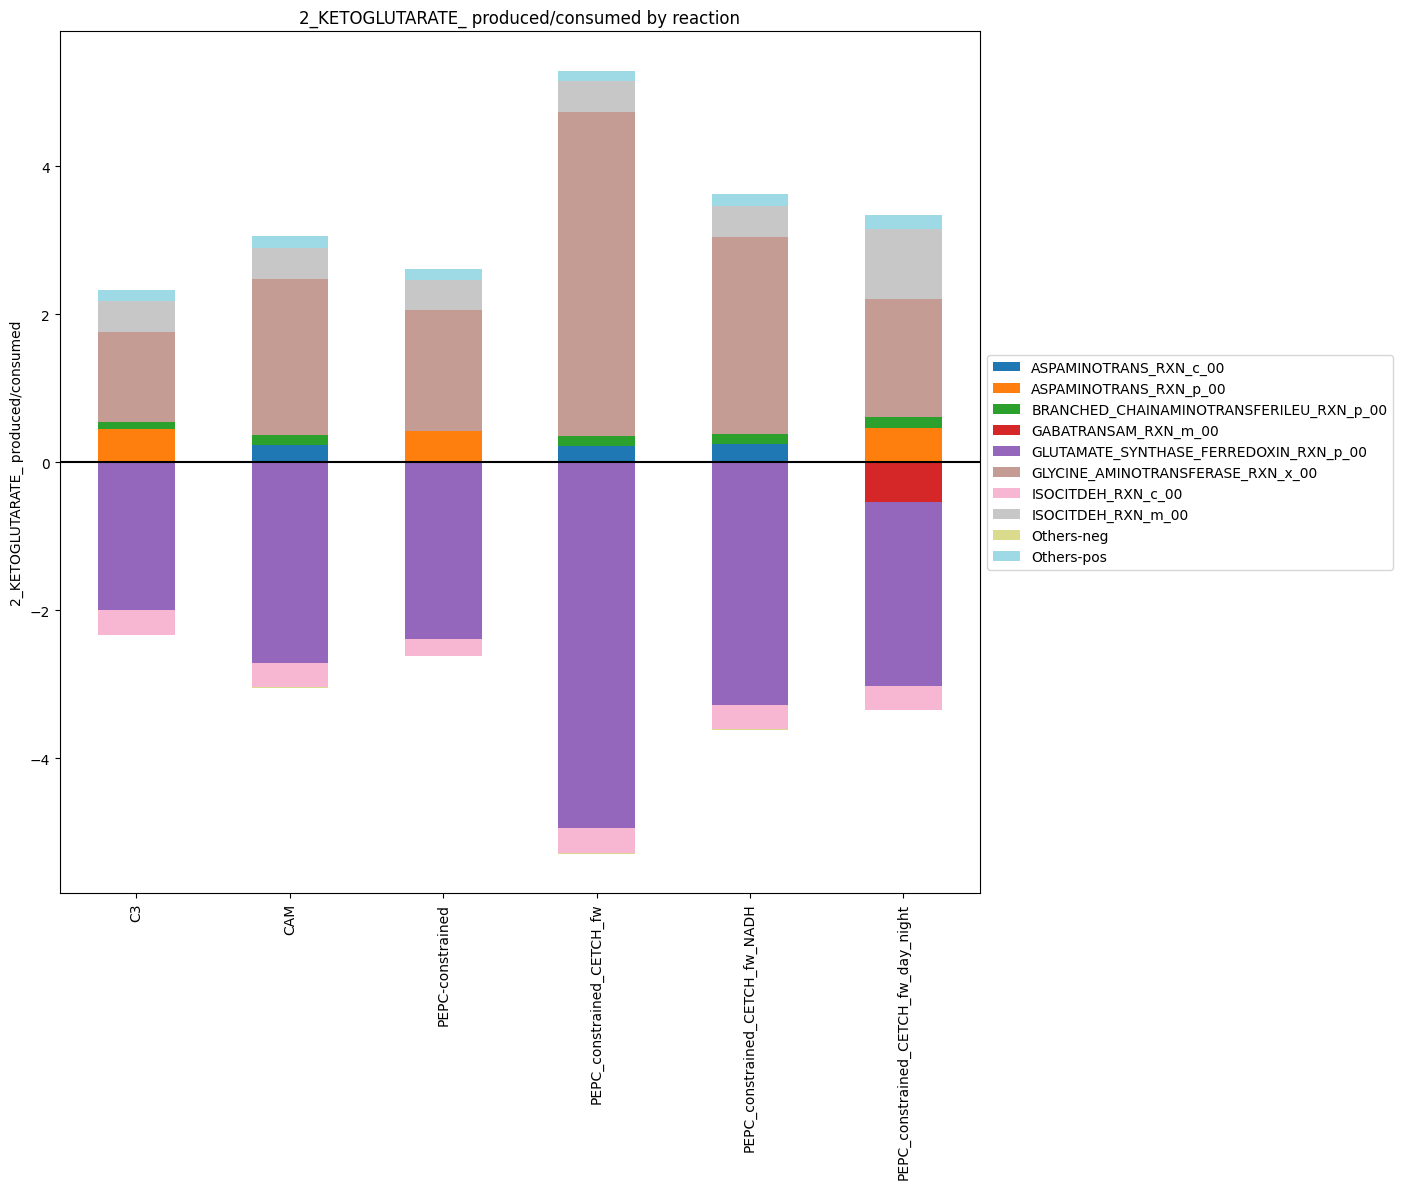

,C3,CAM,PEPC-constrained,PEPC_constrained_CETCH_fw,PEPC_constrained_CETCH_fw_NADH,PEPC_constrained_CETCH_fw_day_night
ASPAMINOTRANS_RXN_c_00,NaN,0.238453,NaN,0.223807,0.243220,NaN
ASPAMINOTRANS_RXN_p_00,0.454590,NaN,0.419391,NaN,NaN,4.626533e-01
BRANCHED_CHAINAMINOTRANSFERILEU_RXN_p_00,0.094113,0.132935,NaN,0.131381,0.141661,1.416609e-01
GABATRANSAM_RXN_m_00,NaN,NaN,NaN,NaN,NaN,-5.312950e-01
GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p_00,-1.988374,-2.715826,-2.384611,-4.943496,-3.274800,-2.486022e+00
GLYCINE_AMINOTRANSFERASE_RXN_x_00,1.203733,2.102795,1.629743,4.375194,2.653043,1.597059e+00
ISOCITDEH_RXN_c_00,-0.344089,-0.321584,-0.229606,-0.332943,-0.326351,-3.263507e-01
ISOCITDEH_RXN_m_00,0.418344,0.418344,0.418344,0.418344,0.418344,9.496395e-01
Others-neg,0.000000,-0.014301,0.000000,-0.013015,-0.014301,-6.294258e-15
Others-pos,0.161682,0.159183,0.146738,0.140727,0.159183,1.926547e-01


In [ ]:
plot_metabolite_budgets(df_name_list, models, solutions, "2_KETOGLUTARATE_", tag= "_00")

In [542]:
diel_model.reactions.get_by_id("GLUTDECARBOX_RXN_c_00")

Reaction identifier,GLUTDECARBOX_RXN_c_00
Name,GLUTDECARBOX-RXN:Glutamate decarboxylase
Memory address,0x7f5703731600
Stoichiometry,GLT_c_00 + PROTON_c_00 --> 4_AMINO_BUTYRATE_c_00 + CARBON_DIOXIDE_c_00 GLT + PROTON --> 4-AMINO-BUTYRATE + CARBON-DIOXIDE
GPR,
Lower bound,0.0
Upper bound,1000.0


In [530]:
diel_model.reactions.get_by_id("MALATE_DEH_RXN_c_00")

Reaction identifier,MALATE_DEH_RXN_c_00
Name,MALATE-DEH-RXN:Malate dehydrogenase
Memory address,0x7f5703882740
Stoichiometry,MAL_c_00 + NAD_c_00 <=> NADH_c_00 + OXALACETIC_ACID_c_00 + PROTON_c_00 MAL + NAD <=> NADH + OXALACETIC_ACID[c] + PROTON
GPR,
Lower bound,-1000.0
Upper bound,1000.0


Total: 0
Total: 0
Total: 0
Total: 3.29229144510859
Total: 1.8663625110444806
Total: 0.6577350985549042


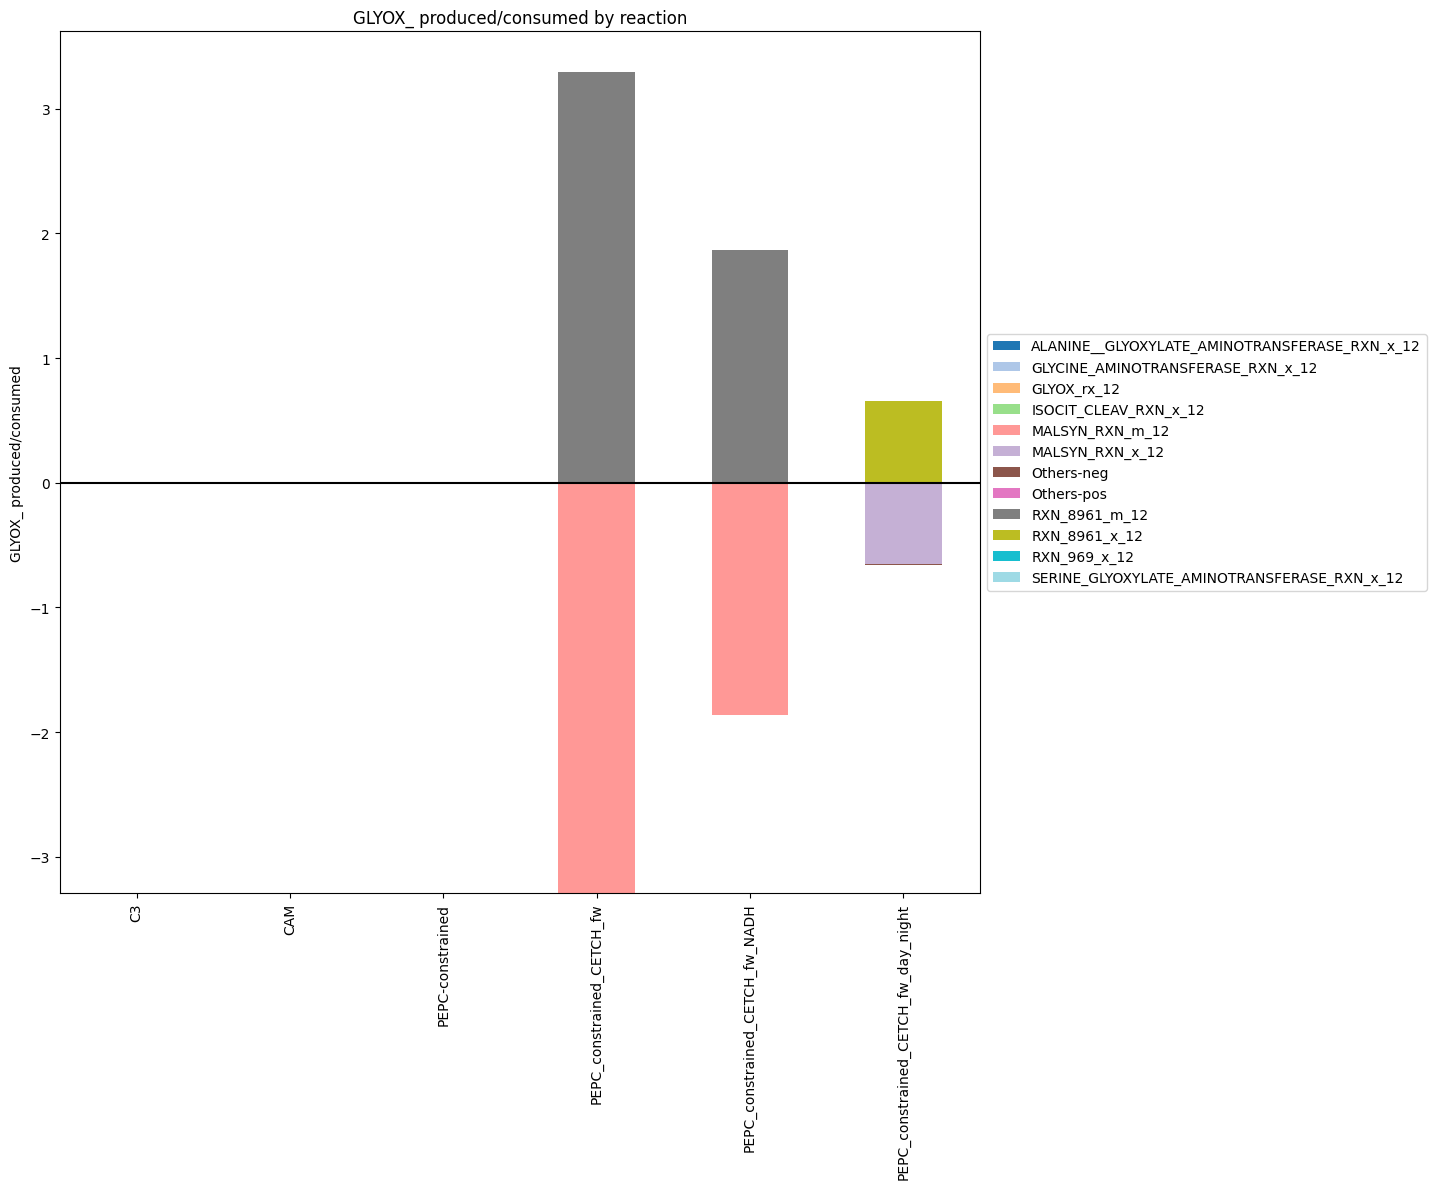

,C3,CAM,PEPC-constrained,PEPC_constrained_CETCH_fw,PEPC_constrained_CETCH_fw_NADH,PEPC_constrained_CETCH_fw_day_night
ALANINE__GLYOXYLATE_AMINOTRANSFERASE_RXN_x_12,-0.0,-0.000000e+00,-0.0,NaN,NaN,NaN
GLYCINE_AMINOTRANSFERASE_RXN_x_12,-0.0,-0.000000e+00,-0.0,NaN,NaN,NaN
GLYOX_rx_12,0.0,0.000000e+00,0.0,NaN,NaN,NaN
ISOCIT_CLEAV_RXN_x_12,0.0,-1.655279e-19,0.0,NaN,NaN,NaN
MALSYN_RXN_m_12,NaN,NaN,NaN,-3.292291,-1.866363,NaN
MALSYN_RXN_x_12,-0.0,-0.000000e+00,-0.0,NaN,NaN,-0.655286
Others-neg,0.0,0.000000e+00,0.0,0.000000,0.000000,-0.002449
Others-pos,0.0,0.000000e+00,0.0,0.000000,0.000000,0.001274
RXN_8961_m_12,NaN,NaN,NaN,3.292291,1.866363,NaN
RXN_8961_x_12,NaN,NaN,NaN,NaN,NaN,0.656461


In [341]:
plot_metabolite_budgets(df_name_list, models, solutions, "GLYOX_")

In [342]:
print(len(models))
print(len(solutions))
print(len(df_name_list))

6
6
6


In [343]:
create_dataframe(df_name_list, solutions, models)


CO2 daytime exchange: 6.643522352606437
CO2 nightime exchange: -1.2359151744723074
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 3.1379011228183975
Carbon night to day: 0.550084153812556
CO2 exchange night:day: 0.17530321456352388
AraCore_Biomass_tx_00 carbon flux: -4.05570538360061
AraCore_Biomass_tx_12 carbon flux: -1.3519017945335363
total carbon biomass flux: -5.407607178134146
total CCE: 0.8139668824945816
nCO2RC: 0.26360495584536014
night CCE1 (carbon in to biomass): 0.4308299534050602
night CCE2 (1 - (carbon lost / carbon in)): 0.6061331679685834
CO2 daytime exchange: 6.643
CO2 nightime exchange: -1.7878542041230546e-15
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 8.49427505332916
Carbon night to day: 6.833525053329159
CO2 exchange night:day: 0.80448596383171
AraCore_Biomass_tx_00 carbon flux: -4.982249999999985
AraCore_Biomass_tx_12 carbon flux: -1.660749999999995
total carbon biomass flux: -6.64299999999998
total CCE: 0.99999999999999

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarnin

,C3,CAM,PEPC-constrained,PEPC_constrained_CETCH_fw,PEPC_constrained_CETCH_fw_NADH,PEPC_constrained_CETCH_fw_day_night
% nCO2R,26.360496,1.000000e+02,39.497327,94.739744,1.000000e+02,1.000000e+02
CIT_v_linker_12_to_00,0.086600,5.877512e-01,0.887362,3.695413,1.271095e+00,7.573593e-01
CO2 daytime exchange,6.643522,6.643000e+00,6.643000,6.643000,6.643000e+00,6.643000e+00
CO2 exchange night:day,0.175303,8.044860e-01,0.690338,0.913151,8.681185e-01,9.357341e-01
CO2 nightime exchange,-1.235915,-1.787854e-15,-0.969988,-0.597409,-3.039352e-14,-9.041434e-14
Carbon day to night,3.137901,8.494275e+00,7.712411,24.281285,1.259275e+01,2.584184e+01
Carbon night to day,0.550084,6.833525e+00,5.324170,22.172479,1.093200e+01,2.418109e+01
MAL_v_linker_12_to_00,0.000000,8.267544e-01,0.000000,0.000000,8.263573e-01,0.000000e+00
Photon flux,111.328905,1.391162e+02,122.340179,200.000000,1.602163e+02,1.347967e+02
Rubisco flux,7.929695,9.792442e+00,8.487373,14.191300,1.102959e+01,9.432019e+00


In [344]:
df_C4, sol_C4 = parameter_scan_CO2(CAM_constrained_CETCH_model_fw_NADH, "AraCore_Biomass_tx_total", "CO2_tx_00", 0, 17, 1, pFBA=True, 
                    CO2_refixation_allowed=True, verbose=True, iterations=50, 
                    double_ub = False, m=0.01025582745716949, b =-0.01170011252656307)

Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total


Model iteration feasible. Objective flux: 0.0
----- Cytosol -----
producing CO2:	CO2_pc_12	0.209172
consuming CO2:	ISOCITDEH_RXN_c_12	-0.418344
consuming CO2:	CO2_xc_12	-1.924384
producing CO2:	CO2_mc_12	1.715212
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.418344
----- Plastid -----
consuming CO2:	CO2_pc_12	0.209172
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.209172
----- Mitochondrion -----
producing CO2:	ISOCITDEH_RXN_m_12	0.418344
producing CO2:	PYRUVDEH_RXN_m_12	3.221252
consuming CO2:	CO2_mc_12	1.715212
consuming CO2:	RXN_8957_m_12	1.924384
----- Peroxisome -----
producing CO2:	CO2_xc_12	-1.924384
consuming CO2:	RXN_18384_x_12	1.924384

CO2 produced: 4.26711
CO2 consumed: -4.26711
CO2 exchange: 0.0

nocturnal CO2 refixation coeffient: 1.0


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0115412
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.025206
producing HCO3-:	RXN0_5224_c_12	0.025206
producing CO2:	CO2_pc_12	0.237767
consuming CO2:	ISOCITDEH_RXN_c_12	-0.413728
consuming CO2:	CO2_xc_12	-1.935071
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.003275
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000278
producing CO2:	CO2_mc_12	1.716709
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.4155
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.025206
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000477
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00074
producing CO2:	RXN_9652_p_12	0.002225
producing CO2:	RXN_9650_p_12	0.002225
producing CO2:	2.3.1.180_RXN_p_12	0.002225
producing CO2:	RXN_9654_p_12	0.002225
consuming CO2:	RXN0_5224_p_12	0.015575
producing HCO3-:	RXN0_5224_p_12	0.015575
consuming CO2:	CO2_pc_12	0.

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 3      Scan value: 2 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0230823
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.050412
producing HCO3-:	RXN0_5224_c_12	0.050412
producing CO2:	CO2_pc_12	0.266361
consuming CO2:	ISOCITDEH_RXN_c_12	-0.409112
consuming CO2:	CO2_xc_12	-1.945759
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.006549
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000556
producing CO2:	CO2_mc_12	1.718207
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.412655
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.050412
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000954
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00148
producing CO2:	RXN_9652_p_12	0.00445
producing CO2:	RXN_9650_p_12	0.00445
producing CO2:	2.3.1.180_RXN_p_12	0.00445
producing CO2:	RXN_9654_p_12	0.00445
consuming CO2:	RXN0_5224_p_12	0.03115
producing HCO3-:	RXN0_5224_p_12	0.03115
consuming CO2:	CO2_pc_12	0.2663

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 4      Scan value: 3 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0346235
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.075618
producing HCO3-:	RXN0_5224_c_12	0.075618
producing CO2:	CO2_pc_12	0.294955
consuming CO2:	ISOCITDEH_RXN_c_12	-0.404496
consuming CO2:	CO2_xc_12	-1.956446
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.009824
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000834
producing CO2:	CO2_mc_12	1.719704
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.40981
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.075618
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.001432
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00222
producing CO2:	RXN_9652_p_12	0.006675
producing CO2:	RXN_9650_p_12	0.006675
producing CO2:	2.3.1.180_RXN_p_12	0.006675
producing CO2:	RXN_9654_p_12	0.006675
consuming CO2:	RXN0_5224_p_12	0.046725
producing HCO3-:	RXN0_5224_p_12	0.046725
consuming CO2:	CO2_pc_12	0

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 5      Scan value: 4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0461646
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.100824
producing HCO3-:	RXN0_5224_c_12	0.100824
producing CO2:	CO2_pc_12	0.32355
consuming CO2:	ISOCITDEH_RXN_c_12	-0.39988
consuming CO2:	CO2_xc_12	-1.967133
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.013099
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001112
producing CO2:	CO2_mc_12	1.721201
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.406966
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.100824
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.001909
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00296
producing CO2:	RXN_9652_p_12	0.0089
producing CO2:	RXN_9650_p_12	0.0089
producing CO2:	2.3.1.180_RXN_p_12	0.0089
producing CO2:	RXN_9654_p_12	0.0089
consuming CO2:	RXN0_5224_p_12	0.0623
producing HCO3-:	RXN0_5224_p_12	0.0623
consuming CO2:	CO2_pc_12	0.32355
produc

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 6      Scan value: 5 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0577058
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.126029
producing HCO3-:	RXN0_5224_c_12	0.126029
producing CO2:	CO2_pc_12	0.352144
consuming CO2:	ISOCITDEH_RXN_c_12	-0.395264
consuming CO2:	CO2_xc_12	-1.97782
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.016373
producing CO2:	GLUTDECARBOX_RXN_c_12	0.00139
producing CO2:	CO2_mc_12	1.722698
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.404121
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.126029
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002386
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.0037
producing CO2:	RXN_9652_p_12	0.011125
producing CO2:	RXN_9650_p_12	0.011125
producing CO2:	2.3.1.180_RXN_p_12	0.011125
producing CO2:	RXN_9654_p_12	0.011125
consuming CO2:	RXN0_5224_p_12	0.077875
producing HCO3-:	RXN0_5224_p_12	0.077875
consuming CO2:	CO2_pc_12	0.3

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 7      Scan value: 6 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.069247
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.151235
producing HCO3-:	RXN0_5224_c_12	0.151235
producing CO2:	CO2_pc_12	0.380738
consuming CO2:	ISOCITDEH_RXN_c_12	-0.390648
consuming CO2:	CO2_xc_12	-1.988507
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.019648
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001668
producing CO2:	CO2_mc_12	1.724196
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.401276
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.151235
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.002863
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.004439
producing CO2:	RXN_9652_p_12	0.01335
producing CO2:	RXN_9650_p_12	0.01335
producing CO2:	2.3.1.180_RXN_p_12	0.01335
producing CO2:	RXN_9654_p_12	0.01335
consuming CO2:	RXN0_5224_p_12	0.09345
producing HCO3-:	RXN0_5224_p_12	0.09345
consuming CO2:	CO2_pc_12	0.3807

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 8      Scan value: 7 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0807881
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.176441
producing HCO3-:	RXN0_5224_c_12	0.176441
consuming CO2:	ISOCITDEH_RXN_c_12	-0.386032
consuming CO2:	CO2_xc_12	-1.999194
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.022922
producing CO2:	GLUTDECARBOX_RXN_c_12	0.001946
producing CO2:	CO2_mc_12	2.135026
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.398432
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.176441
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.003341
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005179
producing CO2:	RXN_9652_p_12	0.015575
producing CO2:	RXN_9650_p_12	0.015575
producing CO2:	2.3.1.180_RXN_p_12	0.015575
producing CO2:	RXN_9654_p_12	0.015575
consuming CO2:	RXN0_5224_p_12	0.109025
producing HCO3-:	RXN0_5224_p_12	0.109025
producing CO2:	1.2.1.2_RXN_p_12	0.002581
consuming HCO3-:	

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 9      Scan value: 8 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0923293
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.201647
producing HCO3-:	RXN0_5224_c_12	0.201647
consuming CO2:	ISOCITDEH_RXN_c_12	-0.381416
consuming CO2:	CO2_xc_12	-2.009881
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.026197
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002224
producing CO2:	CO2_mc_12	2.165117
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.395587
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.201647
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.003818
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.005919
producing CO2:	RXN_9652_p_12	0.0178
producing CO2:	RXN_9650_p_12	0.0178
producing CO2:	2.3.1.180_RXN_p_12	0.0178
producing CO2:	RXN_9654_p_12	0.0178
consuming CO2:	RXN0_5224_p_12	0.1246
producing HCO3-:	RXN0_5224_p_12	0.1246
producing CO2:	1.2.1.2_RXN_p_12	0.00295
consuming HCO3-:	ACETYL_COA_CA

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 10      Scan value: 9 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1038704
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.226853
producing HCO3-:	RXN0_5224_c_12	0.226853
producing CO2:	CO2_pc_12	0.466522
consuming CO2:	ISOCITDEH_RXN_c_12	-0.3768
consuming CO2:	CO2_xc_12	-2.020568
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.029472
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002502
producing CO2:	CO2_mc_12	1.728688
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.392743
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.226853
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.004295
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.006659
producing CO2:	RXN_9652_p_12	0.020025
producing CO2:	RXN_9650_p_12	0.020025
producing CO2:	2.3.1.180_RXN_p_12	0.020025
producing CO2:	RXN_9654_p_12	0.020025
consuming CO2:	RXN0_5224_p_12	0.140175
producing HCO3-:	RXN0_5224_p_12	0.140175
consuming CO2:	CO2_pc_12	

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 11      Scan value: 10 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1135915
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.248084
producing HCO3-:	RXN0_5224_c_12	0.248084
producing CO2:	CO2_pc_12	0.282949
consuming CO2:	ISOCITDEH_RXN_c_12	-0.372912
consuming CO2:	CO2_xc_12	-1.7503
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.03223
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002736
producing CO2:	CO2_mc_12	1.809303
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.390346
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.248084
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.004697
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.006741
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007282
producing CO2:	RXN_9652_p_12	0.021899
producing CO2:	RXN_9650_p_12	0.021899
producing CO2:	2.3.1.180_RXN_p_12	0.021899
producing CO2:	RXN_9654_p_12	0.021899
consuming CO2:	RXN0_5224_p_12	0.153294
producing HCO3

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 12      Scan value: 11 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1207627
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.263746
producing HCO3-:	RXN0_5224_c_12	0.263746
producing CO2:	CO2_pc_12	0.078438
consuming CO2:	ISOCITDEH_RXN_c_12	-0.370043
consuming CO2:	CO2_xc_12	-1.039334
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.034265
producing CO2:	GLUTDECARBOX_RXN_c_12	0.002909
producing CO2:	CO2_mc_12	1.884526
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.390508
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.263746
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.004994
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.007167
consuming CO2:	RXN_8957_c_12	0.193339
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.007742
producing CO2:	RXN_9652_p_12	0.023282
producing CO2:	RXN_9650_p_12	0.023282
producing CO2:	2.3.1.180_RXN_p_12	0.023282
producing CO2:	RXN_9654_p_12	0.023282
consuming CO

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 13      Scan value: 12 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.12758
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.278635
producing HCO3-:	RXN0_5224_c_12	0.278635
producing CO2:	CO2_pc_12	0.565095
consuming CO2:	ISOCITDEH_RXN_c_12	-0.367317
consuming CO2:	CO2_xc_12	-0.269216
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036199
producing CO2:	GLUTDECARBOX_RXN_c_12	0.003073
producing CO2:	CO2_mc_12	0.890158
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.388937
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.278635
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005276
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.007571
consuming CO2:	RXN_8957_c_12	0.035491
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.008179
producing CO2:	RXN_9652_p_12	0.024596
producing CO2:	RXN_9650_p_12	0.024596
producing CO2:	2.3.1.180_RXN_p_12	0.024596
producing CO2:	RXN_9654_p_12	0.024596
consuming CO2:

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 14      Scan value: 13 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1285757
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.059147
producing HCO3-:	RXN0_5224_c_12	0.059147
producing CO2:	CO2_pc_12	0.552189
consuming CO2:	ISOCITDEH_RXN_c_12	-0.274426
consuming CO2:	CO2_xc_12	-0.221715
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036481
producing CO2:	GLUTDECARBOX_RXN_c_12	0.01239
producing CO2:	CO2_mc_12	0.834872
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.340407
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.059147
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005317
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.00763
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024788
producing CO2:	RXN_9650_p_12	0.024788
producing CO2:	2.3.1.180_RXN_p_12	0.024788
producing CO2:	RXN_9654_p_12	0.024788
consuming CO2:	RXN0_5224_p_12	0.173515
producing HCO3-:	RXN0_5224_p_12	0.173515
consuming CO2:	CO2_pc_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 15      Scan value: 14 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1285757
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.059147
producing HCO3-:	RXN0_5224_c_12	0.059147
producing CO2:	CO2_pc_12	0.552189
consuming CO2:	ISOCITDEH_RXN_c_12	-0.274426
consuming CO2:	CO2_xc_12	-0.221715
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036481
producing CO2:	GLUTDECARBOX_RXN_c_12	0.01239
producing CO2:	CO2_mc_12	0.834872
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.340407
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.059147
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005317
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.00763
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024788
producing CO2:	RXN_9650_p_12	0.024788
producing CO2:	2.3.1.180_RXN_p_12	0.024788
producing CO2:	RXN_9654_p_12	0.024788
consuming CO2:	RXN0_5224_p_12	0.173515
producing HCO3-:	RXN0_5224_p_12	0.173515
consuming CO2:	CO2_pc_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 16      Scan value: 15 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1285757
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.059147
producing HCO3-:	RXN0_5224_c_12	0.059147
producing CO2:	CO2_pc_12	0.552189
consuming CO2:	ISOCITDEH_RXN_c_12	-0.274426
consuming CO2:	CO2_xc_12	-0.221715
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036481
producing CO2:	GLUTDECARBOX_RXN_c_12	0.01239
producing CO2:	CO2_mc_12	0.834872
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.340407
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.059147
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005317
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.00763
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024788
producing CO2:	RXN_9650_p_12	0.024788
producing CO2:	2.3.1.180_RXN_p_12	0.024788
producing CO2:	RXN_9654_p_12	0.024788
consuming CO2:	RXN0_5224_p_12	0.173515
producing HCO3-:	RXN0_5224_p_12	0.173515
consuming CO2:	CO2_pc_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


------- Scan iteration: 17      Scan value: 16 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.1285757
----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	0.059147
producing HCO3-:	RXN0_5224_c_12	0.059147
producing CO2:	CO2_pc_12	0.552189
consuming CO2:	ISOCITDEH_RXN_c_12	-0.274426
consuming CO2:	CO2_xc_12	-0.221715
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.036481
producing CO2:	GLUTDECARBOX_RXN_c_12	0.01239
producing CO2:	CO2_mc_12	0.834872
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.340407
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.059147
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.005317
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.00763
----- Plastid -----
producing CO2:	RXN_9652_p_12	0.024788
producing CO2:	RXN_9650_p_12	0.024788
producing CO2:	2.3.1.180_RXN_p_12	0.024788
producing CO2:	RXN_9654_p_12	0.024788
consuming CO2:	RXN0_5224_p_12	0.173515
producing HCO3-:	RXN0_5224_p_12	0.173515
consuming CO2:	CO2_pc_

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


0.0 0.0
9.97098523306073e-05 -0.0010150537053587845
0.13077700381143378 -1.7759502537368914
0.0541148972882379 -0.9311429274656275
0.043263457904943306 -1.0308394652854318
0.5887432056122325 -7.553432488099415
0.0030559201973281987 -0.437534341419935
0.09198824818163044 -1.6149880976789501
0.024704951262682 0.4912686886060906
-0.5568643915805174 7.491581030931644
-0.04672963096184987 1.5446144235252226
-0.09308316514375647 2.1794247229629367
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


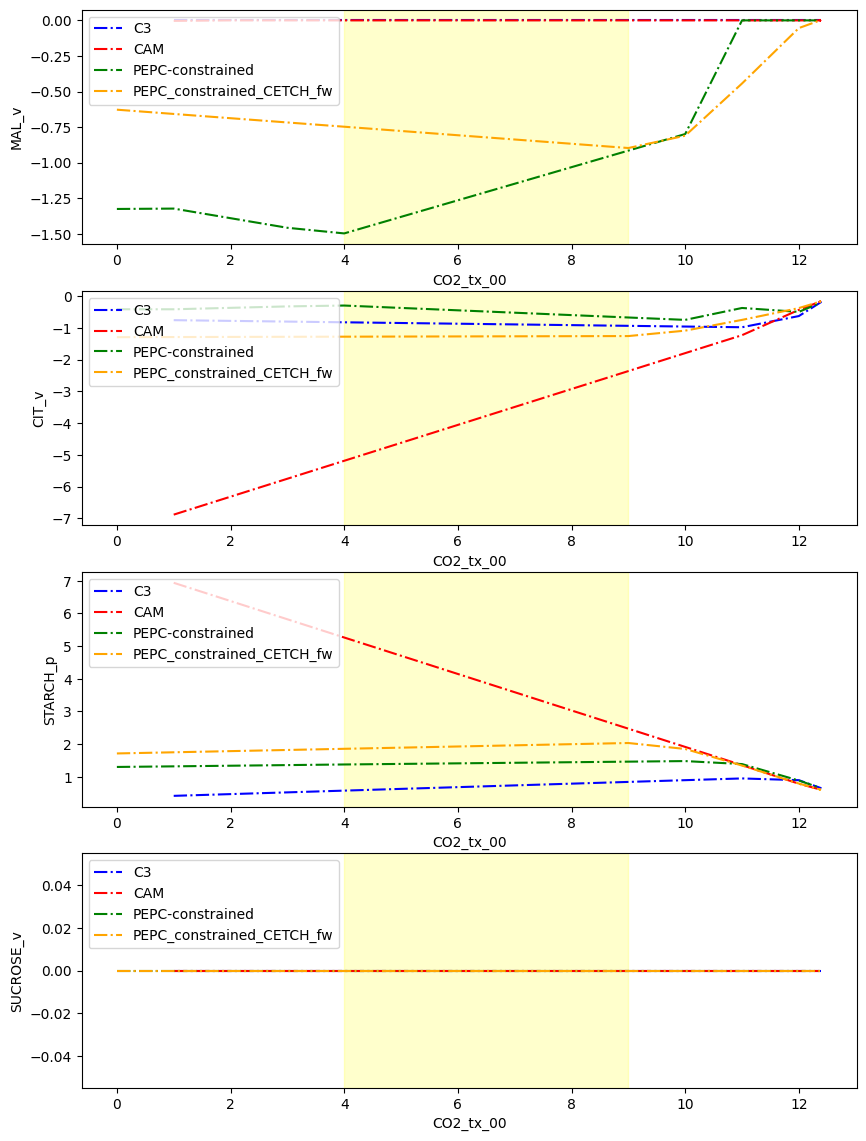

In [345]:
df_list = [df_C1, df_C2, df_C3, df_C4]
x_axis = "CO2_tx_00"
y_axes = ["MAL_v_linker_12_to_00", "CIT_v_linker_12_to_00", "STARCH_p_linker_00_to_12", "SUCROSE_v_linker_00_to_12"]

import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(nrows=len(y_axes), ncols=1, figsize=(10, 14))
colors = ['blue','red','green', 'orange']


for count, y_axis in enumerate(y_axes):
    
    
    for df, df_name in zip(df_list, df_name_list):
        # Assign colors to lines based on dataframe index
        color_index = df_name_list.index(df_name)
        color = colors[color_index % len(colors)]
    
        x1 = df.T[x_axis]
        x1 = x1.dropna()

        
        y1 = df.T[y_axis]
        y1 = y1.dropna()

        axs[count].plot(x1, y1, color=color, label=df_name, linestyle ="dashdot")

        # Calculate slope using linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x1, y1)

        print(slope, intercept)

    axs[count].set_xlabel(x_axis)
    axs[count].set_ylabel(y_axis.replace("_linker_00_to_12", "").replace("_linker_12_to_00", ""))
    axs[count].legend(loc='upper left')
    # Highlight the region between 4 and 9 on the x-axis
    axs[count].axvspan(4, 9, alpha=0.2, color='yellow')

plt.legend(loc='upper left')
plt.show()


## Accumulation

In [346]:
for rxn in CAM_constrained_model_opt.reactions:
    if "linker" in rxn.id and abs(rxn.flux) > 0:
        print(rxn.id, rxn.flux)

NITRATE_v_linker_12_to_00 0.19907915503353538
CIT_v_linker_12_to_00 0.887361700655111
PHE_v_linker_00_to_12 0.0038854923953479093
STARCH_p_linker_00_to_12 0.7179468793026285
MET_v_linker_00_to_12 0.0017789691724168681
4_AMINO_BUTYRATE_v_linker_00_to_12 0.0015772435196370219
SUC_v_linker_00_to_12 0.6900150459996724
PRO_v_linker_00_to_12 0.10860030181668441
ILE_v_linker_00_to_12 0.0026996346718739994
LEU_v_linker_00_to_12 0.0058828303199978315


In [350]:
for rxn in CAM_constrained_CETCH_model_fw_day_night_opt.reactions:
    if rxn.id[:-5] in cetch_dr_dict.keys() and abs(rxn.flux)>0 :
        print(rxn.id,"\t", rxn.flux, "\n")

MALSYN_RXN_x_12 	 0.6552857510492385 

METHYLMALONYL_COA_MUT_RXN_p_00 	 0.7854773343406384 

RXN_8891_p_00 	 -0.7854773343406384 

RXN_11002_p_00 	 0.7854773343406384 

RXN_18387_p_00 	 0.25418229416954696 

RXN_11002_m_00 	 0.5312950401710941 

RXN_18387_m_00 	 0.5312950401710942 

RXN_18387_p_12 	 -1.1507347364036103e-16 

RXN_8957_p_12 	 -1.4536957014358995e-16 

RXN_16391_p_12 	 -1.4536957014358995e-16 

RXN_8890_c_12 	 0.6564613195025215 

RXN_8957_c_12 	 0.6564613195025215 

RXN_18387_m_12 	 0.5312950401710916 

RXN_8961_x_12 	 0.6564613195025214 

RXN_18384_x_12 	 0.7854773343406385 

RXN_8890_x_12 	 0.6603110550092115 

RXN_16391_x_12 	 0.6564613195025215 

RXN_8958_x_12 	 0.6564613195025213 

RXN_18381_x_12 	 0.6564613195025213 

RXN_8960_x_12 	 -0.6564613195025214 



In [406]:
for linker in CAM_constrained_CETCH_model_fw_day_night_opt.reactions:
    if "linker" in linker.id and abs(linker.flux) >0:
        print(linker.id, linker.flux)

NITRATE_v_linker_12_to_00 0.23311827415798195
CIT_v_linker_12_to_00 0.75735928215769
PHE_v_linker_00_to_12 0.004549844916233711
STARCH_p_linker_00_to_12 0.5323276019654728
MET_v_linker_00_to_12 0.0020831423721092883
ILE_v_linker_00_to_12 0.13217724071060144
LEU_v_linker_00_to_12 0.006888693349794061
4_HYDROXY_BUTYRATE_v_linker_00_to_12 0.5312950401710914
4_HYDROXY_BUTYRYL_COA_v_linker_00_to_12 0.785477334340641
CPD_17635_v_linker_12_to_00 2.4476276212910916e-32
METHYL_MALONYL_COA_v_linker_12_to_00 0.7854773343406384


In [527]:
diel_model.reactions.GLUTDECARBOX_RXN_c_00

Reaction identifier,GLUTDECARBOX_RXN_c_00
Name,GLUTDECARBOX-RXN:Glutamate decarboxylase
Memory address,0x7f5703731600
Stoichiometry,GLT_c_00 + PROTON_c_00 --> 4_AMINO_BUTYRATE_c_00 + CARBON_DIOXIDE_c_00 GLT + PROTON --> 4-AMINO-BUTYRATE + CARBON-DIOXIDE
GPR,
Lower bound,0.0
Upper bound,1000.0


## Total CETCH cycle reaction

In [356]:
total = Reaction("Total_CETCH")


for reaction in cetch_model.reactions:
    print(reaction)
    if reaction.id == "RXN_8891" or reaction.id == "RXN_8960":
        for met in reaction.metabolites:
            total.add_metabolites({met:(-1)*reaction.get_coefficient(cetch_model.metabolites.get_by_id(met.id))})
    else:
        for met in reaction.metabolites:
            total.add_metabolites({met:reaction.get_coefficient(cetch_model.metabolites.get_by_id(met.id))})

MALSYN_RXN: ACETYL_COA + GLYOX + WATER --> CO_A + MAL + PROTON
RXN_8961: CPD_9409 <=> GLYOX + PROPIONYL_COA
RXN_15977: OXYGEN_MOLECULE + PROPIONYL_COA <=> ACRYLYL_COA + HYDROGEN_PEROXIDE
RXN_18384: ACRYLYL_COA + CARBON_DIOXIDE + NADPH <=> METHYL_MALONYL_COA + NADP
METHYLMALONYL_COA_MUT_RXN: METHYL_MALONYL_COA <=> SUC_COA
RXN_8891: CO_A + NADP + SUCC_S_ALD <=> NADPH + PROTON + SUC_COA
RXN_11002: NADPH + PROTON + SUCC_S_ALD <=> 4_HYDROXY_BUTYRATE + NADP
RXN_18387: 4_HYDROXY_BUTYRATE + ATP + CO_A <=> 4_HYDROXY_BUTYRYL_COA + ADP + Pi
RXN_8890: 4_HYDROXY_BUTYRYL_COA <=> CROTONYL_COA + WATER
RXN_8957: CARBON_DIOXIDE + CROTONYL_COA + NADPH <=> CPD_9406 + NADP
RXN_16391: CPD_9406 <=> CPD_17635
RXN_8958: CPD_17635 <=> CPD_9407
RXN_18381: CPD_9407 + OXYGEN_MOLECULE <=> CPD_9408 + HYDROGEN_PEROXIDE
RXN_8960: CPD_9409 <=> CPD_9408 + WATER


In [357]:
total

Reaction identifier,Total_CETCH
Name,
Memory address,0x7f56e4eaeb30
Stoichiometry,ACETYL_COA + ATP + 2.0 CARBON_DIOXIDE + 4.0 NADPH + 2.0 OXYGEN_MOLECULE + PROTON + WATER --> ADP + CO_A + 2.0 HYDROGEN_PEROXIDE + MAL + 4.0 NADP + Pi acetyl-CoA + ATP + 2.0 CO2 + 4.0 NADPH + 2.0 dioxygen + Proton + Water --> ADP + coenzyme A + 2.0 hydrogen peroxide + (S)-malate + 4.0 NADP+ + phosphate
GPR,
Lower bound,0.0
Upper bound,1000.0


In [358]:
def plot_carbon_flux(models, df_name_list):
    import matplotlib.pyplot as plt
    import pandas as pd

    df = pd.DataFrame()

    # create a list of data for the y-axis and add it to the DataFrame
    for i, model in enumerate(models):
        new_col = calc_carbon_flux(model, "AraCore_Biomass_tx")
        df.insert(i, df_name_list[i], new_col)

    # create a subplot for each row in the DataFrame
    fig, axs = plt.subplots(df.shape[0], figsize=(10, df.shape[0]*3))

    # plot bars for each column in the DataFrame
    for i, ax in enumerate(axs):
        bars = ax.bar(df.columns, df.iloc[i])
        ax.set_title(df.T.columns[i])
        ax.set_ylabel(df.T.columns[i])

        # set the color of the bars based on the label
        for bar, label in zip(bars, df.columns):
            if 'CETCH' in label:
                bar.set_color('orange')
            else:
                bar.set_color('lightblue')

    # display the plots
    plt.tight_layout()
    plt.show()


CO2 daytime exchange: 6.643522352606437
CO2 nightime exchange: -1.2359151744723074
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 3.1379011228183975
Carbon night to day: 0.550084153812556
CO2 exchange night:day: 0.17530321456352388
AraCore_Biomass_tx_00 carbon flux: -4.05570538360061
AraCore_Biomass_tx_12 carbon flux: -1.3519017945335363
total carbon biomass flux: -5.407607178134146
total CCE: 0.8139668824945816
nCO2RC: 0.26360495584536014
night CCE1 (carbon in to biomass): 0.4308299534050602
night CCE2 (1 - (carbon lost / carbon in)): 0.6061331679685834
CO2 daytime exchange: 6.643
CO2 nightime exchange: -1.7878542041230546e-15
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 8.49427505332916
Carbon night to day: 6.833525053329159
CO2 exchange night:day: 0.80448596383171
AraCore_Biomass_tx_00 carbon flux: -4.982249999999985
AraCore_Biomass_tx_12 carbon flux: -1.660749999999995
total carbon biomass flux: -6.64299999999998
total CCE: 0.99999999999999

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarnin

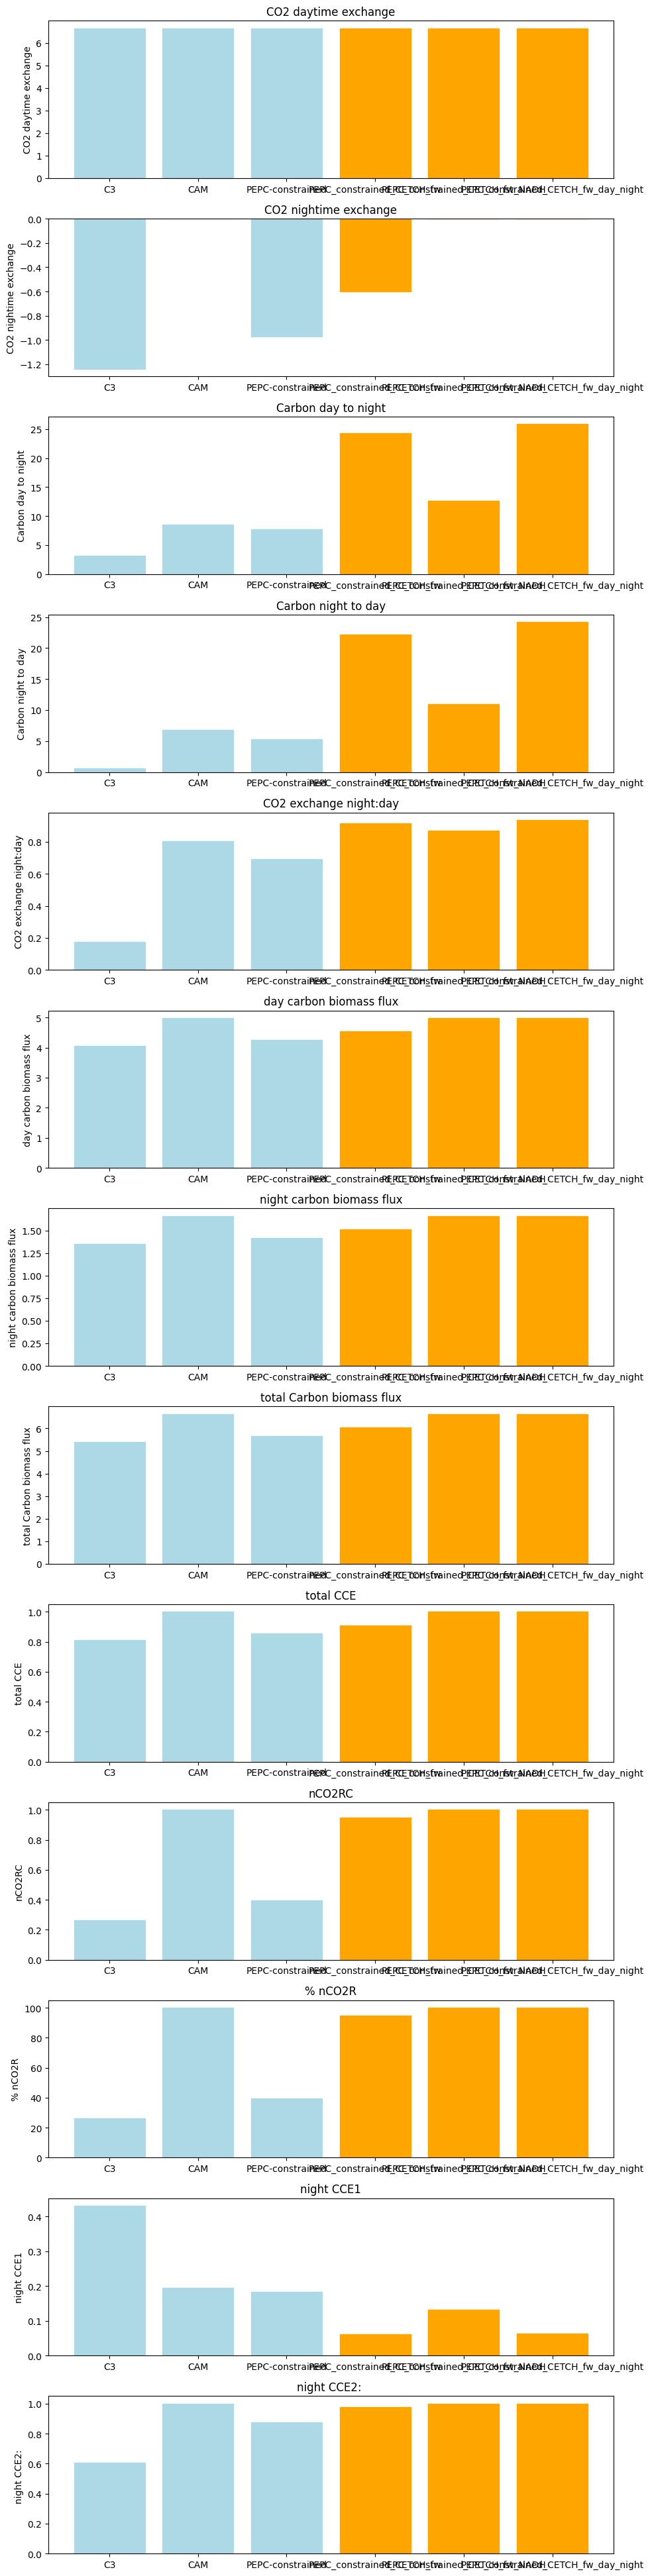

In [359]:
plot_carbon_flux(models, df_name_list)

In [360]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
reactions,,,,,,,,,,,,,,,,,
PRO_PROTON_vc_00,0.000000,0.000000,0.000000,0.000000,0.000000,3.029691e-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ca_tx_00,0.000000,0.007617,0.015234,0.022851,0.030469,3.808583e-02,0.045703,0.053320,0.060937,0.068554,0.074970,0.079703,0.084203,0.084860,0.084860,0.084860,0.084860
H2O_xc_00,0.895257,1.427653,1.826178,2.224704,2.623229,3.021754e+00,3.420280,3.818805,4.217331,4.615856,4.860607,4.903333,4.917363,4.917564,4.917564,4.917564,4.917564
sCIT_biomass_00,0.000000,-0.002283,-0.004565,-0.006848,-0.009131,-1.141366e-02,-0.013696,-0.015979,-0.018262,-0.020545,-0.022467,-0.023886,-0.025234,-0.025431,-0.025431,-0.025431,-0.025431
ACETYLGLUTKIN_RXN_p_00,0.000000,0.002153,0.004306,0.006458,0.008611,1.076396e-02,0.012917,0.015070,0.017222,0.019375,0.021188,0.022526,0.023798,0.023983,0.023983,0.023983,0.023983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
daytime CO2 uptake ub,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000e+00,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000
scan process ub,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000e+00,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000
total aa day,0.000000,0.021933,0.043865,0.065798,0.087731,1.096635e-01,0.131596,0.153529,0.175462,0.197394,0.215868,0.229496,0.242452,0.245393,0.245393,0.245393,0.245393


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarnin

CO2 daytime exchange: 6.643
CO2 nightime exchange: -0.9699877418896142
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 7.712411010347877
Carbon night to day: 5.324170203930666
CO2 exchange night:day: 0.6903379756067375
AraCore_Biomass_tx_00 carbon flux: -4.254759193582797
AraCore_Biomass_tx_12 carbon flux: -1.4182530645275988
total carbon biomass flux: -5.673012258110395
total CCE: 0.8539834800708093
nCO2RC: 0.3949732675309189
night CCE1 (carbon in to biomass): 0.1838923084654985
night CCE2 (1 - (carbon lost / carbon in)): 0.8742302840722357
CO2 daytime exchange: 6.643
CO2 nightime exchange: -0.5974088905621442
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 24.28128534525963
Carbon night to day: 22.17247867733632
CO2 exchange night:day: 0.9131509457618145
AraCore_Biomass_tx_00 carbon flux: -4.534193332078992
AraCore_Biomass_tx_12 carbon flux: -1.511397777359664
total carbon biomass flux: -6.045591109438656
total CCE: 0.9100694128312292
nCO2RC: 0.9

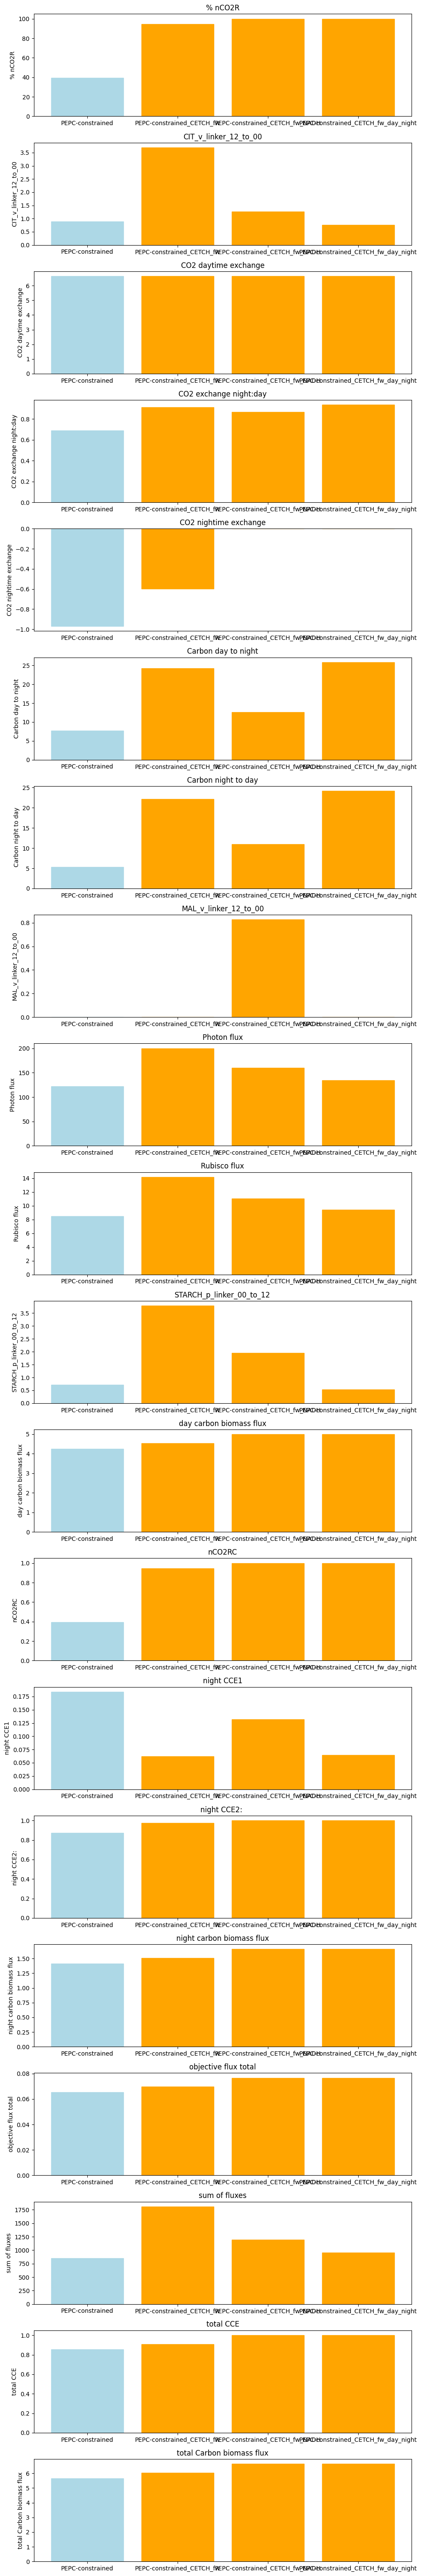

In [361]:
import matplotlib.pyplot as plt
import pandas as pd


# create a list of labels for the x-axis
labels = df_name_list


# create a DataFrame
df = create_dataframe(
    ["PEPC-constrained", "PEPC-constrained_CETCH_fw", "PEPC-constrained_CETCH_fw_NADH", "PEPC-constrained_CETCH_fw_day_night"], 
    [solution_CAM_constrained, solution_CAM_constrained_CETCH_fw , solution_CAM_constrained_CETCH_model_fw_NADH, solution_CAM_constrained_CETCH_model_fw_day_night], 
    [CAM_constrained_model, CAM_constrained_CETCH_model_fw, CAM_constrained_CETCH_model_fw_NADH_opt, CAM_constrained_CETCH_model_fw_day_night_opt])

# create a subplot for each row in the DataFrame
fig, axs = plt.subplots(df.shape[0], figsize=(10, df.shape[0]*3))

# plot bars for each column in the DataFrame
for i, ax in enumerate(axs):
    bars = ax.bar(df.columns, df.iloc[i])
    ax.set_title(df.T.columns[i])
    ax.set_ylabel(df.T.columns[i])



    # set the color of the bars based on the label
    for bar, label in zip(bars, df.columns):
        if 'CETCH' in label:
            bar.set_color('orange')
        else:
            bar.set_color('lightblue')

# display the plots
plt.tight_layout()
plt.show()

In [362]:
create_dataframe(df_name_list, solutions, models)


CO2 daytime exchange: 6.643522352606437
CO2 nightime exchange: -1.2359151744723074
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 3.1379011228183975
Carbon night to day: 0.550084153812556
CO2 exchange night:day: 0.17530321456352388
AraCore_Biomass_tx_00 carbon flux: -4.05570538360061
AraCore_Biomass_tx_12 carbon flux: -1.3519017945335363
total carbon biomass flux: -5.407607178134146
total CCE: 0.8139668824945816
nCO2RC: 0.26360495584536014
night CCE1 (carbon in to biomass): 0.4308299534050602
night CCE2 (1 - (carbon lost / carbon in)): 0.6061331679685834
CO2 daytime exchange: 6.643
CO2 nightime exchange: -1.7878542041230546e-15
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 8.49427505332916
Carbon night to day: 6.833525053329159
CO2 exchange night:day: 0.80448596383171
AraCore_Biomass_tx_00 carbon flux: -4.982249999999985
AraCore_Biomass_tx_12 carbon flux: -1.660749999999995
total carbon biomass flux: -6.64299999999998
total CCE: 0.99999999999999

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarnin

,C3,CAM,PEPC-constrained,PEPC_constrained_CETCH_fw,PEPC_constrained_CETCH_fw_NADH,PEPC_constrained_CETCH_fw_day_night
% nCO2R,26.360496,1.000000e+02,39.497327,94.739744,1.000000e+02,1.000000e+02
CIT_v_linker_12_to_00,0.086600,5.877512e-01,0.887362,3.695413,1.271095e+00,7.573593e-01
CO2 daytime exchange,6.643522,6.643000e+00,6.643000,6.643000,6.643000e+00,6.643000e+00
CO2 exchange night:day,0.175303,8.044860e-01,0.690338,0.913151,8.681185e-01,9.357341e-01
CO2 nightime exchange,-1.235915,-1.787854e-15,-0.969988,-0.597409,-3.039352e-14,-9.041434e-14
Carbon day to night,3.137901,8.494275e+00,7.712411,24.281285,1.259275e+01,2.584184e+01
Carbon night to day,0.550084,6.833525e+00,5.324170,22.172479,1.093200e+01,2.418109e+01
MAL_v_linker_12_to_00,0.000000,8.267544e-01,0.000000,0.000000,8.263573e-01,0.000000e+00
Photon flux,111.328905,1.391162e+02,122.340179,200.000000,1.602163e+02,1.347967e+02
Rubisco flux,7.929695,9.792442e+00,8.487373,14.191300,1.102959e+01,9.432019e+00


### check CETCH in different compartments

# test different compartment combinations at night

In [363]:
cetch_model_fw

Name,
Memory address,7f56f85930d0
Number of metabolites,27
Number of reactions,14
Number of genes,0
Number of groups,0
Objective expression,0
Compartments,u


11
11


Objective: AraCore_Biomass_tx_total
Objective: AraCore_Biomass_tx_total
Objective: AraCore_Biomass_tx_total
Objective: AraCore_Biomass_tx_total
Objective: AraCore_Biomass_tx_total
Objective: AraCore_Biomass_tx_total
Objective: AraCore_Biomass_tx_total
Objective: AraCore_Biomass_tx_total
Objective: AraCore_Biomass_tx_total
Objective: AraCore_Biomass_tx_total
Objective: AraCore_Biomass_tx_total
--- 1 --- c
Objective: AraCore_Biomass_tx_total
--- 2 --- p
Objective: AraCore_Biomass_tx_total
--- 3 --- x


Ignoring reaction 'MALSYN_RXN_x_12' since it already exists.


Objective: AraCore_Biomass_tx_total
--- 4 --- m
Objective: AraCore_Biomass_tx_total
--- 5 --- c+p
Objective: AraCore_Biomass_tx_total
--- 6 --- c+m
Objective: AraCore_Biomass_tx_total
--- 7 --- c+x


Ignoring reaction 'MALSYN_RXN_x_12' since it already exists.


Objective: AraCore_Biomass_tx_total
--- 8 --- c+p+m
Objective: AraCore_Biomass_tx_total
--- 9 --- c+p+x


Ignoring reaction 'MALSYN_RXN_x_12' since it already exists.


Objective: AraCore_Biomass_tx_total
--- 10 --- c+m+x


Ignoring reaction 'MALSYN_RXN_x_12' since it already exists.


Objective: AraCore_Biomass_tx_total
--- 11 --- c+p+m+x


Ignoring reaction 'MALSYN_RXN_x_12' since it already exists.


Objective: AraCore_Biomass_tx_total


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarnin

CO2 daytime exchange: 6.643
CO2 nightime exchange: -0.9699877418895807
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 7.712411010349206
Carbon night to day: 5.324170203932025
CO2 exchange night:day: 0.6903379756067947
AraCore_Biomass_tx_00 carbon flux: -4.254759193582803
AraCore_Biomass_tx_12 carbon flux: -1.418253064527601
total carbon biomass flux: -5.673012258110404
total CCE: 0.8539834800708143
nCO2RC: 0.39497326753107975
night CCE1 (carbon in to biomass): 0.1838923084654671
night CCE2 (1 - (carbon lost / carbon in)): 0.8742302840722618
CO2 daytime exchange: 6.643
CO2 nightime exchange: -0.9699877418895805
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 7.712411010349246
Carbon night to day: 5.324170203932067
CO2 exchange night:day: 0.6903379756067966
AraCore_Biomass_tx_00 carbon flux: -4.254759193582799
AraCore_Biomass_tx_12 carbon flux: -1.4182530645275997
total carbon biomass flux: -5.673012258110399
total CCE: 0.8539834800708144
nCO2RC: 0.

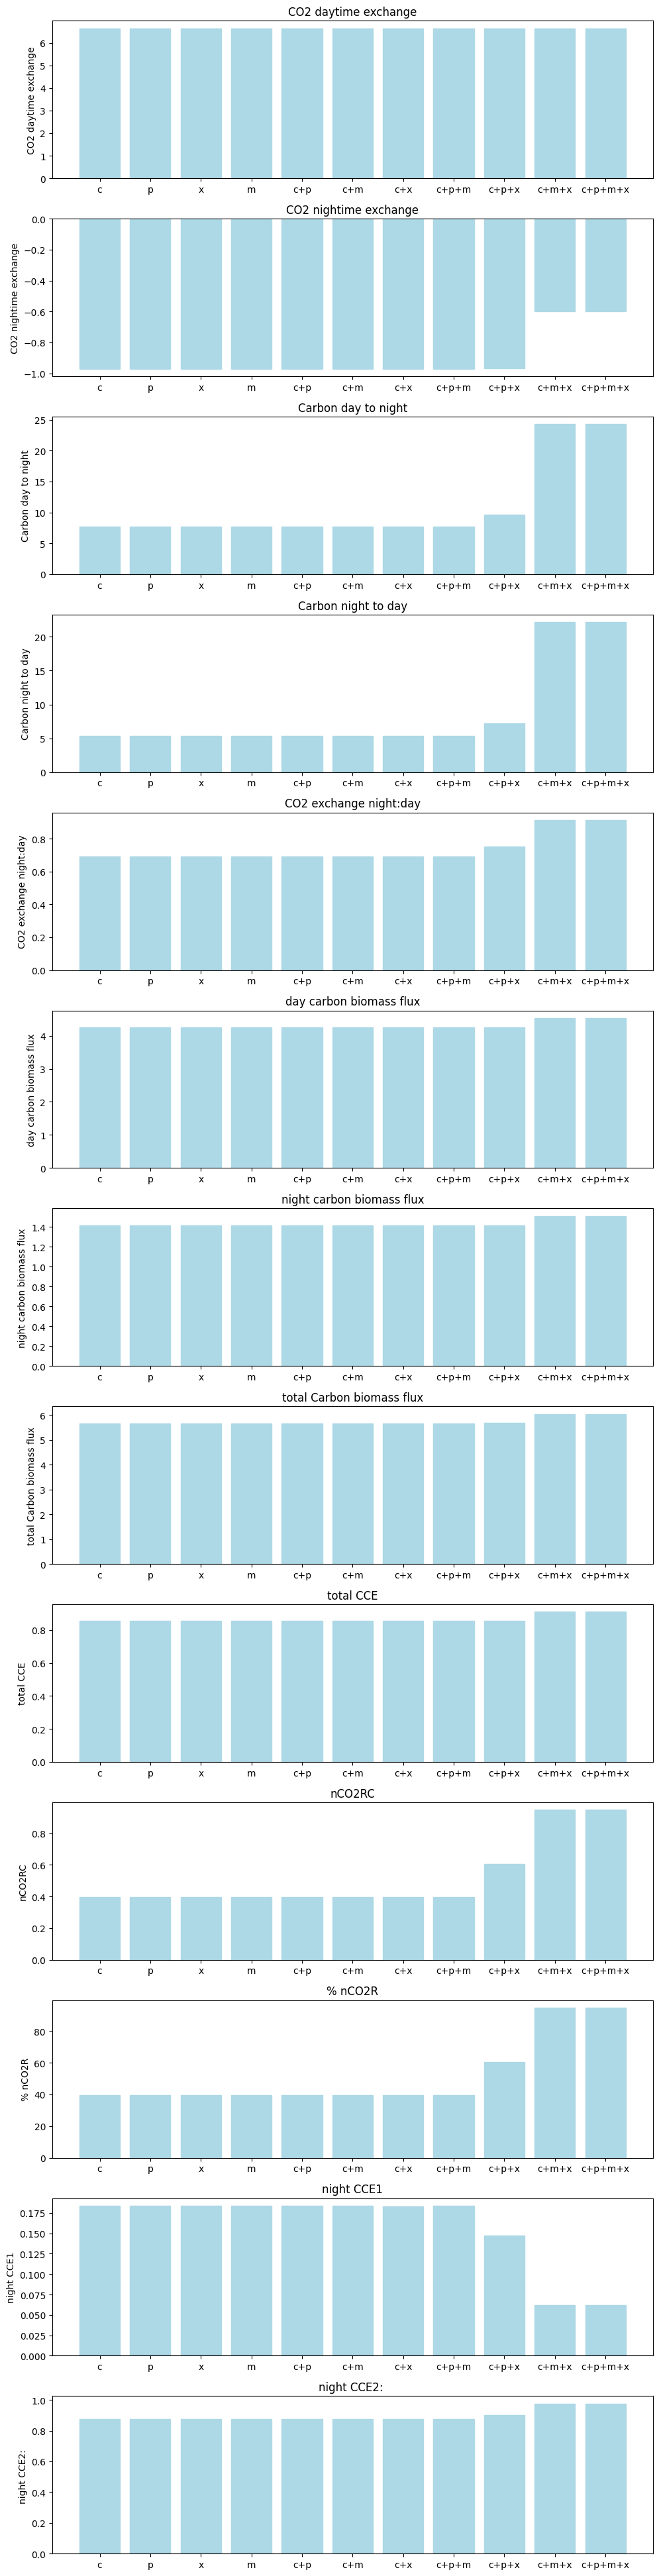

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarnin

CO2 daytime exchange: 6.643
CO2 nightime exchange: -0.9699877418895807
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 7.712411010349206
Carbon night to day: 5.324170203932025
CO2 exchange night:day: 0.6903379756067947
AraCore_Biomass_tx_00 carbon flux: -4.254759193582803
AraCore_Biomass_tx_12 carbon flux: -1.418253064527601
total carbon biomass flux: -5.673012258110404
total CCE: 0.8539834800708143
nCO2RC: 0.39497326753107975
night CCE1 (carbon in to biomass): 0.1838923084654671
night CCE2 (1 - (carbon lost / carbon in)): 0.8742302840722618
CO2 daytime exchange: 6.643
CO2 nightime exchange: -0.9699877418895805
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 7.712411010349246
Carbon night to day: 5.324170203932067
CO2 exchange night:day: 0.6903379756067966
AraCore_Biomass_tx_00 carbon flux: -4.254759193582799
AraCore_Biomass_tx_12 carbon flux: -1.4182530645275997
total carbon biomass flux: -5.673012258110399
total CCE: 0.8539834800708144
nCO2RC: 0.

In [364]:
compartment_tests = [["_c"], ["_p"], ["_x"], ["_m"], ["_c", "_p"], ["_c", "_m"], ["_c", "_x"], ["_c", "_p", "_m"], ["_c", "_p", "_x"], ["_c", "_m", "_x"], ["_c", "_p", "_m", "_x"]]
df_name_list2 = ["c", "p", "x", "m", "c+p", "c+m", "c+x", "c+p+m", "c+p+x", "c+m+x",  "c+p+m+x"]
print(len(compartment_tests))
print(len(df_name_list2))

CAM_constrained_model_pMDHrev = CAM_constrained_model.copy()


# add catalase to compartments
    #add catalase to cytosol
cat_rxn_c = Reaction("CATAL_RXN_c_12", name="CATAL-RXN:Catalase")
cat_rxn_c.add_metabolites({diel_model.metabolites.HYDROGEN_PEROXIDE_c_12: -2,
                            diel_model.metabolites.WATER_c_12: 2,
                            diel_model.metabolites.OXYGEN_MOLECULE_c_12: 1})
cat_rxn_c.lower_bound = 0
cat_rxn_c.upper_bound = 1000
CAM_constrained_model_pMDHrev.add_reactions([cat_rxn_c])

    #add catalase to mitochondria
cat_rxn_m = Reaction("CATAL_RXN_m_12", name="CATAL-RXN:Catalase")
cat_rxn_m.add_metabolites({diel_model.metabolites.HYDROGEN_PEROXIDE_m_12: -2,
                            diel_model.metabolites.WATER_m_12: 2,
                            diel_model.metabolites.OXYGEN_MOLECULE_m_12: 1})
cat_rxn_m.lower_bound = 0
cat_rxn_m.upper_bound = 1000
CAM_constrained_model_pMDHrev.add_reactions([cat_rxn_m])


model1 = CAM_constrained_model_pMDHrev.copy()
model2 = CAM_constrained_model_pMDHrev.copy()
model3 = CAM_constrained_model_pMDHrev.copy()
model4 = CAM_constrained_model_pMDHrev.copy()
model5 = CAM_constrained_model_pMDHrev.copy()
model6 = CAM_constrained_model_pMDHrev.copy()
model7 = CAM_constrained_model_pMDHrev.copy()

model11 = CAM_constrained_model_pMDHrev.copy()
model12 = CAM_constrained_model_pMDHrev.copy()
model13 = CAM_constrained_model_pMDHrev.copy()

model15 = CAM_constrained_model_pMDHrev.copy()

model_list = [model1, model2, model3, model4, model5, model6, model7,  model11, model12, model13, model15]

solution1, _ = optimise_model(model1, "AraCore_Biomass_tx_total", pFBA=True)
solution2, _ = optimise_model(model2, "AraCore_Biomass_tx_total", pFBA=True)
solution3, _ = optimise_model(model3, "AraCore_Biomass_tx_total", pFBA=True)
solution4, _ = optimise_model(model4, "AraCore_Biomass_tx_total", pFBA=True)
solution5, _ = optimise_model(model5, "AraCore_Biomass_tx_total", pFBA=True)
solution6, _ = optimise_model(model6, "AraCore_Biomass_tx_total", pFBA=True)
solution7, _ = optimise_model(model7, "AraCore_Biomass_tx_total", pFBA=True)
solution11, _ = optimise_model(model11, "AraCore_Biomass_tx_total", pFBA=True)
solution12, _ = optimise_model(model12, "AraCore_Biomass_tx_total", pFBA=True)
solution13, _ = optimise_model(model13, "AraCore_Biomass_tx_total", pFBA=True)

solution15, _ = optimise_model(model15, "AraCore_Biomass_tx_total", pFBA=True)

solution_list = [solution1, solution2, solution3, solution4, solution5, solution6, solution7, solution11, solution12, solution13, solution15]

for count, comp_set in enumerate(compartment_tests):
    print("---", count+1, "---", df_name_list2[count])
    #add pathway to compartments
    model_list[count], _ = add_pathway_to_compartments(model_list[count],
                                            cetch_model_fw, ["_12"], comp_set, transporters=True, 
                                            linkers=False, charge_states=False, charge_states_dict={})
    
    #optimise model
    solution_list[count], model_list[count] = optimise_model(model_list[count], "AraCore_Biomass_tx_total", pFBA=True)



# create a list of labels for the x-axis
labels = df_name_list2

# create a DataFrame
df = pd.DataFrame()

# create a list of data for the y-axis and add it to the DataFrame
for i, model in enumerate(model_list):
    new_col = calc_carbon_flux(model,"AraCore_Biomass_tx")
    df.insert(i, labels[i], new_col)


# create a subplot for each row in the DataFrame
fig, axs = plt.subplots(df.shape[0], figsize=(10, df.shape[0]*3))

# plot bars for each column in the DataFrame
for i, ax in enumerate(axs):
    bars = ax.bar(df.columns, df.iloc[i])
    ax.set_title(df.T.columns[i])
    ax.set_ylabel(df.T.columns[i])



    # set the color of the bars based on the label
    for bar, label in zip(bars, df.columns):
        if 'CETCH' in label:
            bar.set_color('orange')
        else:
            bar.set_color('lightblue')

# display the plots
plt.tight_layout()
plt.show()

df_comp_test = create_dataframe(df_name_list2, solution_list, models=model_list)
for sol in solution_list:
    print(sol.fluxes["AraCore_Biomass_tx_total"])
    print(sol.fluxes["Photon_tx_00"])


In [365]:
calc_met_turnover(CAM_constrained_CETCH_model_fw_NADH_opt, ["ATP", "NADPH", "NADH", "CARBON_DIOXIDE"], "AraCore_Biomass_tx_total")

Results normalised by specfied reaction flux: AraCore_Biomass_tx_total 0.07666792062071374


Turnover: 	 Total 	 Day 	 Night
ATP 	 1176.6088985352537 	 913.1994150333701 	 263.40948350188376
NADPH 	 465.43659409687905 	 442.3634433592091 	 23.073150737670005
NADH 	 201.12653823226069 	 70.02932087531703 	 131.0972173569437
CARBON_DIOXIDE 	 527.1117359012808 	 414.355881204328 	 112.75585469695302


In [366]:
NADPH_rxns =[]
NADPH_rxns_dict ={"bounds to not produce":[], "ATP-consuming":[], "CO2-producing":[], "other":[]}
for rxn in diel_model.reactions.query("_12"):
    NADPH_cont = False
    rxns_mets =[]
    for met in rxn.metabolites:
        rxns_mets.append(met.id[:-4])
        if met.id.startswith("NADPH_"):
            NADPH_rxns.append(rxn.id)
            NADPH_cont = True
            NADPH_met = met
    if NADPH_cont:
        NADPH_coeff = rxn.get_coefficient(NADPH_met)
        if (NADPH_coeff < 0 and rxn.lower_bound >=0) or (NADPH_coeff > 0 and rxn.upper_bound <=0):

            NADPH_rxns_dict["bounds to not produce"].append(rxn.id)

        else:
            NADPH_rxns_dict["other"].append(rxn.id)
            if "ATP_" in rxns_mets:
                print(rxn)
                NADPH_rxns_dict["ATP-consuming"].append(rxn.id)
            if "CARBON_DIOXIDE_" in rxns_mets:
                print(rxn)
                NADPH_rxns_dict["CO2-producing"].append(rxn.id)


print(len(NADPH_rxns))

RXN_5682_p_12: CPD_659_p_12 + NADP_p_12 --> CARBON_DIOXIDE_p_12 + NADPH_p_12 + 0.01 PROTON_p_12 + TYR_p_12
NADH_KINASE_RXN_c_12: ATP_c_12 + NADH_c_12 --> ADP_c_12 + NADPH_c_12 + 0.84 PROTON_c_12
ISOCITDEH_RXN_m_12: NADP_m_12 + THREO_DS_ISO_CITRATE_m_12 <=> 2_KETOGLUTARATE_m_12 + CARBON_DIOXIDE_m_12 + NADPH_m_12
ISOCITDEH_RXN_x_12: NADP_x_12 + THREO_DS_ISO_CITRATE_x_12 <=> 2_KETOGLUTARATE_x_12 + CARBON_DIOXIDE_x_12 + NADPH_x_12
ISOCITDEH_RXN_c_12: NADP_c_12 + THREO_DS_ISO_CITRATE_c_12 <=> 2_KETOGLUTARATE_c_12 + CARBON_DIOXIDE_c_12 + NADPH_c_12
MALIC_NADP_RXN_p_12: MAL_p_12 + NADP_p_12 --> CARBON_DIOXIDE_p_12 + NADPH_p_12 + PYRUVATE_p_12
MALIC_NADP_RXN_c_12: MAL_c_12 + NADP_c_12 --> CARBON_DIOXIDE_c_12 + NADPH_c_12 + PYRUVATE_c_12
6PGLUCONDEHYDROG_RXN_p_12: CPD_2961_p_12 + NADP_p_12 --> CARBON_DIOXIDE_p_12 + NADPH_p_12 + RIBULOSE_5P_p_12
6PGLUCONDEHYDROG_RXN_c_12: CPD_2961_c_12 + NADP_c_12 --> CARBON_DIOXIDE_c_12 + NADPH_c_12 + RIBULOSE_5P_c_12
PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12: NA

In [367]:
NADPH_rxns_dict

{'bounds to not produce': ['RXN_9532_p_12',
  'ACETOOHBUTREDUCTOISOM_RXN_p_12',
  '1.5.1.8_RXN_c_12',
  'RXN_9536_p_12',
  'MANNOSE_6_PHOSPHATE_6_REDUCTASE_RXN_c_12',
  '1.2.1.13_RXN_p_12',
  'HOMOSERDEHYDROG_RXN_NADP_p_12',
  'MALATE_DEHYDROGENASE_NADP+_RXN_p_12',
  'RXN0_5330_NADP_mc_12',
  'RXN_3522_p_12',
  'Phytol_biosynthesis_p_12',
  'RXN_7677_p_12',
  'ASPARTATE_SEMIALDEHYDE_DEHYDROGENASE_RXN_p_12',
  'NADPHoxm_tx_12',
  'RXN_9514_p_12',
  'DIHYDROPICRED_RXN_NADP_p_12',
  'N_ACETYLGLUTPREDUCT_RXN_p_12',
  'GLUTATHIONE_REDUCT_NADPH_RXN_m_12',
  'GLUTATHIONE_REDUCT_NADPH_RXN_p_12',
  'RXN_9518_p_12',
  'DIHYDROFOLATEREDUCT_RXN_m_12',
  'ACETOLACTREDUCTOISOM_RXN_p_12',
  'RXN_9540_p_12',
  'RXN_9524_p_12',
  'HMBPP_synthesis_p_12',
  'GLUTSEMIALDEHYDROG_RXN_c_12',
  'A_B_oxidation_x_12',
  'THIOREDOXIN_REDUCT_NADPH_RXN_p_12',
  'SHIKIMATE_5_DEHYDROGENASE_RXN_p_12',
  'RXN_9528_p_12',
  'RXN_7676_p_12',
  'RXN_7678_NADP_p_12',
  'NADPHoxc_tx_12',
  'IPP_biosynthesis_c_12',
  'RXN0_

In [525]:
for type in NADPH_rxns_dict:
    print(type)
    for rxn in NADPH_rxns_dict[type]:
        print(diel_model.reactions.get_by_id(rxn).id, "\t", diel_model.reactions.get_by_id(rxn).reaction)

bounds to not produce
RXN_9532_p_12 	 3_oxo_dodecanoyl_ACPs_p_12 + NADPH_p_12 + PROTON_p_12 --> NADP_p_12 + R_3_hydroxydodecanoyl_ACPs_p_12
ACETOOHBUTREDUCTOISOM_RXN_p_12 	 2_ACETO_2_HYDROXY_BUTYRATE_p_12 + NADPH_p_12 + PROTON_p_12 --> 1_KETO_2_METHYLVALERATE_p_12 + NADP_p_12
1.5.1.8_RXN_c_12 	 2_KETOGLUTARATE_c_12 + LYS_c_12 + NADPH_c_12 + PROTON_c_12 --> NADP_c_12 + SACCHAROPINE_c_12 + WATER_c_12
RXN_9536_p_12 	 3_oxo_myristoyl_ACPs_p_12 + NADPH_p_12 + PROTON_p_12 --> NADP_p_12 + R_3_hydroxymyristoyl_ACPs_p_12
MANNOSE_6_PHOSPHATE_6_REDUCTASE_RXN_c_12 	 MANNOSE_6P_c_12 + NADPH_c_12 + PROTON_c_12 --> MANNITOL_1P_c_12 + NADP_c_12
1.2.1.13_RXN_p_12 	 DPG_p_12 + NADPH_p_12 + PROTON_p_12 --> GAP_p_12 + NADP_p_12 + Pi_p_12
HOMOSERDEHYDROG_RXN_NADP_p_12 	 L_ASPARTATE_SEMIALDEHYDE_p_12 + NADPH_p_12 + 1.05 PROTON_p_12 --> HOMO_SER_p_12 + NADP_p_12
MALATE_DEHYDROGENASE_NADP+_RXN_p_12 	 NADPH_p_12 + OXALACETIC_ACID_p_12 + PROTON_p_12 --> MAL_p_12 + NADP_p_12
RXN0_5330_NADP_mc_12 	 NADPH_m_12 + P

In [368]:
for cat in NADPH_rxns_dict:
    print("\n   ", cat, "    ", len(NADPH_rxns_dict[cat]))
    for item in NADPH_rxns_dict[cat]:
        print(diel_model.reactions.get_by_id(item))
        print(diel_model.reactions.get_by_id(item).bounds)


    bounds to not produce      46
RXN_9532_p_12: 3_oxo_dodecanoyl_ACPs_p_12 + NADPH_p_12 + PROTON_p_12 --> NADP_p_12 + R_3_hydroxydodecanoyl_ACPs_p_12
(0.0, 1000.0)
ACETOOHBUTREDUCTOISOM_RXN_p_12: 2_ACETO_2_HYDROXY_BUTYRATE_p_12 + NADPH_p_12 + PROTON_p_12 --> 1_KETO_2_METHYLVALERATE_p_12 + NADP_p_12
(0.0, 1000.0)
1.5.1.8_RXN_c_12: 2_KETOGLUTARATE_c_12 + LYS_c_12 + NADPH_c_12 + PROTON_c_12 --> NADP_c_12 + SACCHAROPINE_c_12 + WATER_c_12
(0.0, 1000.0)
RXN_9536_p_12: 3_oxo_myristoyl_ACPs_p_12 + NADPH_p_12 + PROTON_p_12 --> NADP_p_12 + R_3_hydroxymyristoyl_ACPs_p_12
(0.0, 1000.0)
MANNOSE_6_PHOSPHATE_6_REDUCTASE_RXN_c_12: MANNOSE_6P_c_12 + NADPH_c_12 + PROTON_c_12 --> MANNITOL_1P_c_12 + NADP_c_12
(0.0, 1000.0)
1.2.1.13_RXN_p_12: DPG_p_12 + NADPH_p_12 + PROTON_p_12 --> GAP_p_12 + NADP_p_12 + Pi_p_12
(0.0, 1000.0)
HOMOSERDEHYDROG_RXN_NADP_p_12: L_ASPARTATE_SEMIALDEHYDE_p_12 + NADPH_p_12 + 1.05 PROTON_p_12 --> HOMO_SER_p_12 + NADP_p_12
(0.0, 1000.0)
MALATE_DEHYDROGENASE_NADP+_RXN_p_12: NADPH_p

In [369]:
for item in NADPH_rxns_dict["other"]:
    if item not in NADPH_rxns_dict["ATP-consuming"] and item not in NADPH_rxns_dict["CO2-producing"]:
        print(diel_model.reactions.get_by_id(item))
        print(diel_model.reactions.get_by_id(item).bounds)

PYRROLINECARBDEHYDROG_RXN_NADP_m_12: L_DELTA1_PYRROLINE_5_CARBOXYLATE_m_12 + NADP_m_12 + 2.0 WATER_m_12 --> GLT_m_12 + NADPH_m_12 + 1.12 PROTON_m_12
(0.0, 1000.0)
1.18.1.2_RXN_p_12: NADP_p_12 + PROTON_p_12 + 2.0 Reduced_ferredoxins_p_12 <=> NADPH_p_12 + 2.0 Oxidized_ferredoxins_p_12
(-1000.0, 1000.0)
1.2.1.9_RXN_c_12: GAP_c_12 + NADP_c_12 + WATER_c_12 --> G3P_c_12 + NADPH_c_12 + 2.0 PROTON_c_12
(0.0, 1000.0)
GLU6PDEHYDROG_RXN_p_12: GLC_6_P_p_12 + NADP_p_12 --> D_6_P_GLUCONO_DELTA_LACTONE_p_12 + NADPH_p_12 + PROTON_p_12
(0.0, 1000.0)
GLU6PDEHYDROG_RXN_c_12: GLC_6_P_c_12 + NADP_c_12 --> D_6_P_GLUCONO_DELTA_LACTONE_c_12 + NADPH_c_12 + PROTON_c_12
(0.0, 1000.0)
METHYLENETHFDEHYDROG_NADP_RXN_c_12: METHYLENE_THF_c_12 + NADP_c_12 --> 5_10_METHENYL_THF_c_12 + NADPH_c_12 + 0.68 PROTON_c_12
(0.0, 1000.0)
GLU6PDEHYDROG_RXN_x_12: GLC_6_P_x_12 + NADP_x_12 --> D_6_P_GLUCONO_DELTA_LACTONE_x_12 + NADPH_x_12 + PROTON_x_12
(0.0, 1000.0)


In [370]:
print(len(NADPH_rxns_dict["bounds to not produce"]))
print(len(NADPH_rxns_dict["other"]))

46
18


In [371]:
for rxn in diel_model.metabolites.Oxidized_ferredoxins_p_12.reactions:
    print(rxn)
    print("\n")
    
    # if rxn.get_coefficient(diel_model.metabolites.Oxidized_ferredoxins_p_12) < 0 and rxn.upper_bound >= 0:
    #     print("consuming Ox")
    #     print(rxn)
    #     print("\n")
    #     print(rxn.bounds)
    # if rxn.get_coefficient(diel_model.metabolites.Oxidized_ferredoxins_p_12) > 0 and rxn.lower_bound <= 0:
    #     print("producing Ox")
    #     print(rxn)
    #     print("\n")
    #     print(rxn.bounds)

RXN_15479_p_12: Oxidized_ferredoxins_p_12 + Photon_p_12 + Plastocyanin_Reduced_l_12 --> Oxidized_Plastocyanins_l_12 + Reduced_ferredoxins_p_12


Ferredoxin_Plastoquinone_Reductase_p_12: PLASTOQUINONE_p_12 + 2.0 PROTON_p_12 + 2.0 Reduced_ferredoxins_p_12 --> 2.0 Oxidized_ferredoxins_p_12 + PLASTOQUINOL_1_p_12


RXN_7978_p_12: CPD1F_130_p_12 + OXYGEN_MOLECULE_p_12 + 2.0 PROTON_p_12 + 2.0 Reduced_ferredoxins_p_12 --> CPD1F_131_p_12 + 2.0 Oxidized_ferredoxins_p_12 + WATER_p_12


Octadecadienoyl_ACP_desaturase_p_12: OXYGEN_MOLECULE_p_12 + Octadecadienoyl_ACP_p_12 + 2.0 PROTON_p_12 + 2.0 Reduced_ferredoxins_p_12 --> Octadecatrienoyl_ACP_p_12 + 2.0 Oxidized_ferredoxins_p_12 + 2.0 WATER_p_12


MDA_Fd_Ascorbate_p_12: CPD_318_p_12 + PROTON_p_12 + Reduced_ferredoxins_p_12 --> ASCORBATE_p_12 + Oxidized_ferredoxins_p_12


RXN0_884_p_12: HYDROXY_METHYL_BUTENYL_DIP_p_12 + 2.0 PROTON_p_12 + 2.0 Reduced_ferredoxins_p_12 --> CPD_4211_p_12 + 2.0 Oxidized_ferredoxins_p_12 + WATER_p_12


FERREDOXIN__NITRIT